### visulaizing the  corine images

### The corine land cover classes

In [1]:
clcc ={111:'cont. urban fabric',
 112:'disc urban fabric',
 121:'industrial or commercial units',
 122:'road and rail',
 123:'port areas',
 124:'airports',
 131:'mineral extraction sites',
 132:'dump sites',
 133:'construction sites',
 141:'green urban areas',
 142:'sport and leasure',
 211:'non irregated arable land',
 212:'permenant irregated land',
 213:'rice fields',
 221:'vine yards',
 223:'olive groves',
 231:'pastures',
 241:'annual with perm. crops',
 242:'complex cultivation patters',
 243:'land principally occupied by agriculture',
 244:'agro forest areas',
 311:'broad leaved forest',
 312:'conferous forest',
 313:'mixed forest',
 321:'natural grassland',
 322:'moors and heathland',
 323: 'scierohllous vegitation',
 324:'transitional woodland shrub',
 331: 'beaches dunes and sand plains',
 332:'bare rock',
 333:'sparsely vegetated areas',
 334:'burnt areas',
 335:'glaciers and perpetual snow',
 411:'inland marshes',
 412:'peat bogs',
 421:'salt marshes',
 422:'salines',
 423:'intertidal flats',
 511:'water courses',
 512:'water bodies',
 521:'costal lagoons',
 522:'estuaries',
 523:'sea and ocean'}
 
 
















In [2]:
landcovers = [key for idx, key in enumerate(clcc) ]

In [3]:
landcovers

[111,
 112,
 121,
 122,
 123,
 124,
 131,
 132,
 133,
 141,
 142,
 211,
 212,
 213,
 221,
 223,
 231,
 241,
 242,
 243,
 244,
 311,
 312,
 313,
 321,
 322,
 323,
 324,
 331,
 332,
 333,
 334,
 335,
 411,
 412,
 421,
 422,
 423,
 511,
 512,
 521,
 522,
 523]

### Algorithm to change a segmentation mask into a feature vector 
#### where each element represnts the number of pixels of each class in each segmentation mask
#### The first part is a dataloader for the segmentation mask and the labels of wild and non wild

In [3]:
#final code
# to do list is to build a transparent model to train on the classes
import glob
import os
import torch
from torch.utils.data import Dataset, DataLoader
import pandas as pd
from PIL import Image
import tifffile as tiff
import time
from tqdm import tqdm


class CustomDataset(Dataset):
    def __init__(self, csv_file, root):
        self.data = pd.read_csv(csv_file)
        
        self.image_paths = sorted(glob.glob(os.path.join(root)+ '/*.*'))
        #self.image_paths = (self.data['file'])
        #print(len(self.image_paths))
        #self.image_paths = sorted(glob.glob(os.path.join('/home/ahmedemam576/working_folder/data/anthroprotect/tiles/lcs', self.image_paths)))
        self.labels = self.data['label']

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        
        image_path = self.image_paths[idx]
        
        label = self.labels[idx]

        
        # we need to open the image as a tiff file and take the first channel representing the corine channel
        image = tiff.imread(image_path)
        image = image.astype('int')
        #print(image.shape)
        image = image[:,:,0]

        return image, label

# Path to the CSV file
csv_file = 'infos.csv'

# Create an instance of the custom dataset
dataset = CustomDataset(csv_file,root = r"C:\Users\midok\OneDrive\Desktop\Imam_farag_paper\anthroprotect\tiles\lcs")

# Create a data loader to iterate over the dataset
batch_size = 1
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
# code the image to segmentation mask function:
# to extract the corine channel from the path
#print(len(data_loader))
#print(images[0])
# Iterate over the data loader
array = landcovers
feature_array = []
target_labels = []
for images, labels in tqdm(data_loader):
    # Convert images to segmentation mask here using your own logic
    #print('-------loop is working-------')
    segmentation_mask = images
    #print(len(images))
    # Get the unique land cover classes present in the segmentation mask
    land_cover_classes = torch.unique(segmentation_mask)

    # Compute the number of land cover classes and the maximum number of classes expected
    num_classes = len(land_cover_classes)
    max_num_classes = 44  # Set the maximum number of land cover classes expected in the dataset
    
    
    # create a dictionary to have the key the land cover class code and as the ni. of pixels of this specific land cover class as data
    class_counts = {}
    
    
    
    # Generate the vector with the count of pixels for each land cover class
    
    for class_keys in land_cover_classes:
        class_counts = {key: 0 for key in array}

        if class_keys in landcovers: # to make sure that we only have the corine land cover classess
            

        
            class_rep = torch.sum(segmentation_mask == class_keys)
            #class_keys = class_keys.item
            #class_rep = class_rep.item

            class_counts[class_keys.item()] = class_rep.item()
            #print(class_counts)
            #time.sleep(1)
            
    #print('the label is -->',labels.item())
    # Trim the class_counts tensor to the actual number of classes found
    #class_counts = class_counts[:num_classes]
    
    # Print the class counts vector
    '''print("Class Counts:")
    print(class_counts.values())
   
    
    print('feature_array len-->',len(feature_array),'target_labels len-->',len(target_labels))
    print('feature_array -->',(feature_array),'target_labels -->',(target_labels))
    #print(labels)
    #time.sleep(0)'''
    
    
    feature_array.append(list(class_counts.values()))
    target_labels.append(labels.item())


NameError: name 'landcovers' is not defined

### Dataset and dataloader for the scene classification dataset (Anthroprotect dataset)

In [231]:
import os
import pandas as pd
from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
import tifffile as tiff
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from PIL import Image
import torchvision
import torchvision.transforms as transforms

class CustomDataset(Dataset):
    def __init__(self, csv_file, image_folder, transform=None):
        self.data = pd.read_csv(csv_file)
        self.images = self.data['file']
        self.labels = self.data['label']
        self.image_folder = image_folder
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        image_name = self.images[index]  # Assuming the image names are in the first column of the CSV file
        image_label = self.labels[index]
        # Construct the complete image path by joining the folder path and image name
        image_path = os.path.join(self.image_folder, image_name)

        # Open the image using PIL
        image = tiff.imread(image_path)
        
        #choos ethe number of channels you need
        image= image[:,:,:3]
        #####
        
        image = image.astype('uint8')
        #image = image.astype('int')
        # Apply transformations, if provided
        if self.transform:
            #pil_image = Image.fromarray(image)
            image = self.transform(image)
            
        

            

        return image, image_label
    
    
csv_file =  'infos.csv'
image_folder = '~/working_folder/data/anthroprotect/tiles/s2'
transform = transforms.ToTensor()  # Example transformation, you can add more

dataset = CustomDataset(csv_file, image_folder, transform=transform) # Replace with your actual dataset instantiation

# Define the ratio of the dataset to be used for testing
test_ratio = 0.2

# Calculate the number of samples for testing
test_size = int(test_ratio * len(dataset))

# Calculate the number of samples for training
train_size = len(dataset) - test_size

# Split the dataset into training and testing datasets
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Create DataLoader instances for training and testing datasets
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


# Example usage





FileNotFoundError: [Errno 2] No such file or directory: 'infos.csv'

In [8]:
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((256, 256)),  # Resize the image to (224, 224)
    transforms.ToTensor()  # Convert the PIL Image to tensor
])
scene_dataset= CustomDataset(csv_file, '/home/ahmedemam576/working_folder/data/anthroprotect/tiles/s2',transform)


In [9]:
batch_size = 128  # Define the batch size
data_loader = DataLoader(scene_dataset, batch_size=batch_size, shuffle=True)

len(dataset)

23919

### a classifier for scence classification, with a method to extract a the embeddings from the bottelneck

In [11]:
import torch
import torch.nn as nn


import torch
import torch.nn as nn



class DeepClassifier(nn.Module):
    def __init__(self, num_classes):
        super(DeepClassifier, self).__init__()
        
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        
        self.embedding = nn.Sequential(
            nn.Linear(256 * 16 * 16, 512),
            nn.ReLU(),
            nn.Linear(512, 10),
            nn.ReLU()
        )
        self.classifier = nn.Sequential(
            nn.Linear(10,1),
            nn.Sigmoid())
    
    def forward(self, x):
        features = self.features(x)
        flattened = torch.flatten(features, start_dim=1)
        embedding = self.embedding(flattened)
        output = self.classifier(embedding)
        
        return output, embedding

# Example usage
input_channels = 3
image_size = 256
num_classes = 1
model = DeepClassifier(num_classes)

model = model.to('cuda')

# Training the model
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


### Training of the scene classifier

In [13]:
from tqdm import tqdm
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_epochs = 20
# Assuming you have your training data in a PyTorch DataLoader called "train_loader"
for epoch in tqdm(range(num_epochs), desc="Training Progress"):
    # Variables to keep track of accuracy and total samples
    total_loss = 0.0
    total_samples = 0
    
    for data in data_loader:
        inputs, labels = data  
        labels = labels.float()
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs, encoded_data = model(inputs.float())
        
        
        
        labels = labels.view(-1, 1)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item() * inputs.size(0)
        
        total_samples += inputs.size(0)
        
    mse = total_loss / total_samples
    print(f"Training MSE: {mse:.4f}")



Training Progress:   5%|█▎                       | 1/20 [01:00<19:03, 60.19s/it]

Training MSE: 0.0792



Training Progress:  10%|██▌                      | 2/20 [02:01<18:11, 60.63s/it]

Training MSE: 0.0658



Training Progress:  15%|███▊                     | 3/20 [03:00<17:04, 60.24s/it]

Training MSE: 0.0487



Training Progress:  20%|█████                    | 4/20 [04:01<16:05, 60.33s/it]

Training MSE: 0.0314



Training Progress:  25%|██████▎                  | 5/20 [05:01<15:05, 60.35s/it]

Training MSE: 0.0251



Training Progress:  30%|███████▌                 | 6/20 [06:01<14:04, 60.29s/it]

Training MSE: 0.0217



Training Progress:  35%|████████▊                | 7/20 [07:02<13:05, 60.44s/it]

Training MSE: 0.0179



Training Progress:  40%|██████████               | 8/20 [08:03<12:05, 60.44s/it]

Training MSE: 0.0134



Training Progress:  45%|███████████▎             | 9/20 [09:03<11:03, 60.29s/it]

Training MSE: 0.0127



Training Progress:  50%|████████████            | 10/20 [10:05<10:09, 60.94s/it]

Training MSE: 0.0105



Training Progress:  55%|█████████████▏          | 11/20 [11:06<09:09, 61.07s/it]

Training MSE: 0.0084



Training Progress:  60%|██████████████▍         | 12/20 [12:09<08:13, 61.70s/it]

Training MSE: 0.0053



Training Progress:  65%|███████████████▌        | 13/20 [13:14<07:17, 62.56s/it]

Training MSE: 0.0048



Training Progress:  70%|████████████████▊       | 14/20 [14:17<06:16, 62.82s/it]

Training MSE: 0.0071



Training Progress:  75%|██████████████████      | 15/20 [15:20<05:13, 62.77s/it]

Training MSE: 0.0040



Training Progress:  80%|███████████████████▏    | 16/20 [16:25<04:13, 63.29s/it]

Training MSE: 0.0035



Training Progress:  85%|████████████████████▍   | 17/20 [17:29<03:10, 63.52s/it]

Training MSE: 0.0068



Training Progress:  90%|█████████████████████▌  | 18/20 [18:33<02:07, 63.87s/it]

Training MSE: 0.0040



Training Progress:  95%|██████████████████████▊ | 19/20 [19:38<01:03, 63.97s/it]

Training MSE: 0.0027


Training Progress: 100%|████████████████████████| 20/20 [20:42<00:00, 62.12s/it]

Training MSE: 0.0033


### Logistic regressor

In [ ]:
# the transparent model

from sklearn.linear_model import LogisticRegression


from sklearn.preprocessing import StandardScaler

#add the mbedding here

X = feature_array. append(embedding)


##get the target values from the classifier
target = target_labels


scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)  # Scale the input features

logreg = LogisticRegression(max_iter=1000)



# Fit the model to the data
logreg.fit(X_scaled, target)

# Print the coefficients of the trained model
coefficients = logreg.coef_[0]
for feature, coefficient in zip(clcc.keys(), coefficients):
    print(f"{feature}: {coefficient}")

### visulaization the coefficients of the LR

In [ ]:
#the coefficients of the trained transparent model
import numpy as np
import matplotlib.pyplot as plt

# Assuming you have a trained logistic regression model named `logreg`
coefficients = coefficients
feature_names = list(clcc.values())  # Assuming `input_data` contains the feature names

# Sort the coefficients and feature names in descending order of absolute magnitude
sorted_indices = np.argsort(np.abs(coefficients))[::-1]
sorted_coefficients = coefficients[sorted_indices]
sorted_feature_names = [feature_names[i] for i in sorted_indices]

# Create the bar plot
plt.figure(figsize=(10, 16))
plt.barh(range(len(sorted_coefficients)), sorted_coefficients, align='center')
plt.yticks(range(len(sorted_coefficients)), sorted_feature_names)
plt.xlabel('Coefficient Value')
plt.ylabel('Feature')
plt.title('Importance of Coefficients in Logistic Regression Model')
plt.show()

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming you have a trained logistic regression model named `logreg`

  # Assuming `input_data` contains the feature names

# Sort the coefficients and feature names in descending order of absolute magnitude
sorted_indices = np.argsort(np.abs(coefficients))[::-1]
sorted_coefficients = coefficients[sorted_indices]
sorted_feature_names = [feature_names[i] for i in sorted_indices]

# Separate positive and negative coefficients
positive_indices = np.where(sorted_coefficients >= 0)[0]
negative_indices = np.where(sorted_coefficients < 0)[0]

positive_coefficients = sorted_coefficients[positive_indices]
positive_feature_names = [sorted_feature_names[i] for i in positive_indices]

negative_coefficients = sorted_coefficients[negative_indices]
negative_feature_names = [sorted_feature_names[i] for i in negative_indices]

# Create separate plots for positive and negative coefficients using Seaborn
plt.figure(figsize=(12, 6))

# Positive coefficients plot
plt.subplot(1, 2, 1)
sns.barplot(x=positive_coefficients, y=positive_feature_names)
plt.xlabel('Coefficient Value')
plt.ylabel('Feature')
plt.title('Positive Coefficients')#

# Negative coefficients plot
plt.subplot(1, 2, 2)
sns.barplot(x=negative_coefficients, y=negative_feature_names)
plt.xlabel('Coefficient Value')
plt.ylabel('Feature')
plt.title('Negative Coefficients')

plt.tight_layout()
plt.show()


In [39]:
landcover_classes = [111,
 112,
 121,
 122,
 123,
 124,
 131,
 132,
 133,
 141,
 142,
 211,
 212,
 213,
 221,
 223,
 231,
 241,
 242,
 243,
 244,
 311,
 312,
 313,
 321,
 322,
 323,
 324,
 331,
 332,
 333,
 334,
 335,
 411,
 412,
 421,
 422,
 423,
 511,
 512,
 521,
 522,
 523]


43

### turning the ground truth segmenation masks into one-hot encoded L* W * C matrix 

In [40]:
import pandas as pd
import tifffile as tiff
from tqdm import tqdm
import numpy as np
from PIL import Image
import os




def onehot_code(csv_file, images_folder, onehot_folder):
    #image_path = "onehotcoded_masks"
    image_path=onehot_folder
    csv_file = pd.read_csv(csv_file)
    masks_names= csv_file['file']
    masks_paths = [os.path.join(images_folder, name) for name in masks_names ] # a list of the masks paths
    print(masks_paths[:5])
    for n,mask  in enumerate(tqdm(masks_paths)):
        tiff_mask = tiff.imread(mask)
        target= tiff_mask[:,:,0] # chosse the corine channel
        target = target.astype('uint8')
        


        # Create an empty tensor with the appropriate size
        one_hot = np.zeros((target.shape[0], target.shape[1], len(landcover_classes)))
        

        # Iterate over the unique class codes and assign 1 to the corresponding channel
        for i, code in enumerate(landcover_classes):

            one_hot[:, :, i] = (target == code).astype(int)
            transposed_one_hot = np.transpose(one_hot, (2,0 , 1))
            
        im = tiff.imsave(f"{onehot_folder}/{masks_names[n]}", transposed_one_hot)
      
                    

                
   


        
        
        
        
        
    
    
 



In [41]:
onehot_code('infos.csv','/home/ahmedemam576/working_folder/data/anthroprotect/tiles/lcs',"onehotcoded_masks")

['/home/ahmedemam576/working_folder/data/anthroprotect/tiles/lcs/anthropo_10.20696-59.31534_0.tif', '/home/ahmedemam576/working_folder/data/anthroprotect/tiles/lcs/anthropo_10.20696-59.31534_1.tif', '/home/ahmedemam576/working_folder/data/anthroprotect/tiles/lcs/anthropo_10.20696-59.31534_10.tif', '/home/ahmedemam576/working_folder/data/anthroprotect/tiles/lcs/anthropo_10.20696-59.31534_11.tif', '/home/ahmedemam576/working_folder/data/anthroprotect/tiles/lcs/anthropo_10.20696-59.31534_12.tif']


100%|█████████████████████████████████████| 23919/23919 [14:04<00:00, 28.34it/s]


In [50]:
tiff_mask = tiff.imread('/home/ahmedemam576/greybox/corine_images/onehotcoded_masks/anthropo_10.20696-59.31534_0.tif')


In [67]:
pip install opencv-python

Note: you may need to restart the kernel to use updated packages.


### Fine tunning pretrained segmentation model deeplapv3

In [74]:
import torch
import torchvision.transforms as transforms
from PIL import Image
from torchvision.models import segmentation
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import os
import tifffile as tiff
import cv2

# Custom dataset class
class CustomDataset(Dataset):
    def __init__(self, csv_file, image_folder, target_folder,transform_image=None,transform_target=None):
        
        self.data = pd.read_csv(csv_file)
        
        
        #the scene input images and the target segmentation maps both have the same name but in different folder
        
        
        
        self.image_paths = self.data['file']
        self.image_folder = image_folder
        self.target_folder = target_folder
        
        
        self.transform = transform
        self.transform_target = transform_target

    def __getitem__(self, index):
  

        
        # Construct the complete image path by joining the folder path and image name
        image_name = self.image_paths[index] 
        image_path = os.path.join(self.image_folder, image_name)

        
        # Open the image using PIL
        image = tiff.imread(image_path)
        #choos ethe number of channels you need
        image= image[:,:,:3]

        image = image.astype('uint8')
        
        #
        
        target_path = os.path.join(self.target_folder, image_name)
        target = tiff.imread(target_path)
        target = np.transpose(target, (1,2,0))





        target = cv2.resize(target, dsize=(512, 512), interpolation=cv2.INTER_CUBIC)

        #target = target.astype('uint8')
        
        ## turning the ground truth segmenation mask into a (L,W,CLASSES) one hot-hot encoded matrix
        #target = Image.fromarray(target)
        #target = target.resize((512,512))
        
        
        

        if self.transform:
            
            image = self.transform(image)
            target = self.transform_target(target)
            
            
            

        return image, target

    def __len__(self):
        return len(self.image_paths)
    #-----------------------------------------------------------------------------------#

# Define the paths to your training data


# Set random seed for reproducibility
torch.manual_seed(42)

# Initialize the model and set it to training mode

model = segmentation.deeplabv3_resnet50(pretrained=True)
model.classifier[-1] = torch.nn.Conv2d(256, 43, kernel_size=1)
model.train()
model.to('cuda')

# Set up the optimizer and loss function
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = torch.nn.CrossEntropyLoss()

# Define the transformation for input images and labels
transform = transforms.Compose([
    transforms.ToPILImage(),
    
    transforms.Resize((512,512)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    
])

#transforms.ToPILImage(),
#transform_target =transforms.Compose([transforms.Resize((512, 512)),
#                                         transforms.ToTensor()])

transform_target = transforms.ToTensor()

#---------------------------------------------------------------------------------------------------#

csv_file =  'infos.csv'
image_folder = '/home/ahmedemam576/working_folder/data/anthroprotect/tiles/s2'
target_folder='/home/ahmedemam576/greybox/corine_images/onehotcoded_masks/'
    
# Create the custom dataset
dataset = CustomDataset(csv_file, image_folder, target_folder,transform_image=transform, transform_target =transform_target)

# Create the data loader
dataloader = DataLoader(dataset, batch_size=2, shuffle=True)

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    for images, targets in tqdm(dataloader):
        
        optimizer.zero_grad()
        images, targets = images.cuda(), targets.cuda()
        # Forward pass
        outputs = model(images)        
        loss = criterion(outputs['out'], targets)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item()}")

# Save the fine-tuned model
torch.save(model.state_dict(), 'fine_tuned_model.pth')


/home/ahmedemam576/coding_streak_envionment/Anconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/ahmedemam576/coding_streak_envionment/Anconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
 46%|████████████████▍                   | 5449/11960 [54:16<1:04:51,  1.67it/s]


RuntimeError: CUDA error: unspecified launch failure
CUDA kernel errors might be asynchronously reported at some other API call,so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.

# ----------------------------------------------------------------------------------------------------------

## loading the weights to segmentation mask

In [14]:
import torch
import torchvision.models as models
from torchvision.models import segmentation

# Create an instance of the DeepLabv3 model
model = segmentation.deeplabv3_resnet50(pretrained=True)
model.classifier[-1] = torch.nn.Conv2d(256, 43, kernel_size=1)  # Replace 'num_classes' with your desired number of classes

# Load the saved checkpoint
checkpoint_path = 'fine_model_ep8_BS_4.pth'  # Replace with the actual path to your saved checkpoint file

model.load_state_dict(torch.load(checkpoint_path))



# Optionally, load other items from the checkpoint if needed
# For example, you can load the optimizer state_dict, scheduler state_dict, etc.

# Set the model to evaluation mode
model.eval()
num_params = sum(p.numel() for p in model.parameters())

print("Number of parameters: ", num_params)


# Now you can use the loaded model for inference or further training


Number of parameters:  42009728


## feed the seen images to the segmentation mask

## teach the student from the teacher's predictions

In [15]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class double_conv(nn.Module):
    '''(conv => BN => ReLU) * 2'''
    def __init__(self, in_ch, out_ch):
        super(double_conv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        x = self.conv(x)
        return x


class inconv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(inconv, self).__init__()
        self.conv = double_conv(in_ch, out_ch)

    def forward(self, x):
        x = self.conv(x)
        return x


class down(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(down, self).__init__()
        self.mpconv = nn.Sequential(
            nn.MaxPool2d(2),
            double_conv(in_ch, out_ch)
        )

        '''self.mp = nn.MaxPool2d(2)
        self.dc = double_conv(in_ch, out_ch)'''

    def forward(self, x):
        x = self.mpconv(x)
        return x


class up(nn.Module):
    def __init__(self, in_ch, out_ch, bilinear=True):
        super(up, self).__init__()

        #  would be a nice idea if the upsampling could be learned too,
        #  but my machine do not have enough memory to handle all those weights
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        else:
            self.up = nn.ConvTranspose2d(in_ch//2, in_ch//2, 2, stride=2)

        self.conv = double_conv(in_ch, out_ch)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, (diffX // 2, diffX - diffX//2,
                        diffY // 2, diffY - diffY//2))
        
        # for padding issues, see 
        # https://github.com/HaiyongJiang/U-Net-Pytorch-Unstructured-Buggy/commit/0e854509c2cea854e247a9c615f175f76fbb2e3a
        # https://github.com/xiaopeng-liao/Pytorch-UNet/commit/8ebac70e633bac59fc22bb5195e513d5832fb3bd

        x = torch.cat([x2, x1], dim=1)
        x = self.conv(x)
        return x


class outconv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(outconv, self).__init__()
        self.conv = nn.Conv2d(in_ch, out_ch, 1)

    def forward(self, x):
        x = self.conv(x)
        return x

In [19]:
import torch.nn.functional as F



class UNet(nn.Module):
    def __init__(self, channel_depth, n_channels, n_classes):
        super(UNet, self).__init__()
        self.inc = inconv(n_channels, channel_depth)
        self.down1 = down(channel_depth, channel_depth*2)
        self.down2 = down(channel_depth*2, channel_depth*4)
        self.down3 = down(channel_depth*4, channel_depth*8)
        self.down4 = down(channel_depth*8, channel_depth*8)
        self.up1 = up(channel_depth*16, channel_depth*4)
        self.up2 = up(channel_depth*8, channel_depth*2)
        self.up3 = up(channel_depth*4, channel_depth)
        self.up4 = up(channel_depth*2, channel_depth)
        self.outc = outconv(channel_depth, n_classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        x = self.outc(x)
        return x
        #return x

class UNet16(nn.Module):
    def __init__(self, n_channels, n_classes):
        super(UNet, self).__init__()
        self.inc = inconv(n_channels, 16)
        self.down1 = down(16, 32)
        self.down2 = down(32, 64)
        self.down3 = down(64, 128)
        self.down4 = down(128, 128)
        self.up1 = up(256, 128)
        self.up2 = up(128, 64)
        self.up3 = up(64, 32)
        self.up4 = up(32, 16)
        self.outc = outconv(16, n_classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        x = self.outc(x)
        return F.sigmoid(x)
        #return x


In [27]:
student = UNet(channel_depth = 16, n_channels = 3, n_classes = 43)

num_params = sum(p.numel() for p in student.parameters())

print("Number of parameters: ", num_params)

Number of parameters:  840491


##  Dataset for the teacher

In [30]:
import torch
import torchvision.transforms as transforms
from PIL import Image
from torchvision.models import segmentation
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import os
import tifffile as tiff
import cv2


#dataloader for the teacher

class Train_Dataset(Dataset):
    def __init__(self, csv_file, image_folder, target_folder,transform_image=None,transform_target=None):
        
        self.data = pd.read_csv(csv_file)
        
        
        #the scene input images and the target segmentation maps both have the same name but in different folder
        
        
        
        self.image_paths = self.data['file']
        self.image_folder = image_folder
        self.target_folder = target_folder
        
        
        self.transform = transform
        self.transform_target = transform_target

    def __getitem__(self, index):
  

        
        # Construct the complete image path by joining the folder path and image name
        image_name = self.image_paths[index] 
        image_path = os.path.join(self.image_folder, image_name)

        
        # Open the image using PIL
        image = tiff.imread(image_path)
        #choos ethe number of channels you need
        image= image[:,:,:3]

        image = image.astype('uint8')
        
        #
        
        target_path = os.path.join(self.target_folder, image_name)
        target = tiff.imread(target_path)
        target = np.transpose(target, (1,2,0))





        target = cv2.resize(target, dsize=(512, 512), interpolation=cv2.INTER_CUBIC)

        #target = target.astype('uint8')
        
        ## turning the ground truth segmenation mask into a (L,W,CLASSES) one hot-hot encoded matrix
        #target = Image.fromarray(target)
        #target = target.resize((512,512))
        
        
        

        if self.transform:
            
            image = self.transform(image)
            target = self.transform_target(target)
            
            
            

        return image, target

    def __len__(self):
        return len(self.image_paths)
    #-----------------------------------------------------------------------------------#


    
    
    
    
    




## initialize the models and the dataloader

In [ ]:
# Define the paths to your training data


# Set random seed for reproducibility
torch.manual_seed(42)

# Initialize the model and set it to training mode

model = segmentation.deeplabv3_resnet50(pretrained=False)
model.classifier[-1] = torch.nn.Conv2d(256, 43, kernel_size=1)
model.train()
model.to('cuda')

# Set up the optimizer and loss function
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = torch.nn.CrossEntropyLoss()

# Define the transformation for input images and labels
transform = transforms.Compose([
    transforms.ToPILImage(),
    
    transforms.Resize((512,512)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    
])

#transforms.ToPILImage(),
#transform_target =transforms.Compose([transforms.Resize((512, 512)),
#                                         transforms.ToTensor()])

transform_target = transforms.ToTensor()

#---------------------------------------------------------------------------------------------------#

csv_file =  'infos.csv'
image_folder = '/home/ahmedemam576/working_folder/data/anthroprotect/tiles/s2'
target_folder='/home/ahmedemam576/greybox/corine_images/onehotcoded_masks/'
    
# Create the custom dataset
dataset = Train_Dataset(csv_file, image_folder, target_folder,transform_image=transform, transform_target =transform_target)

# Create the data loader
dataloader = DataLoader(dataset, batch_size=2, shuffle=True)


                #############################################################################
    

## loss functions 

In [2]:
import torch
import torch.nn.functional as F

#NOTE: all verifications for the size is left

T = 5
alpha = 0.9


def dice_loss(output, gt, smooth = 1):
    output = output.clamp(min = 0, max = 1)
    intersection = torch.sum(gt*output)
    union = torch.sum(gt) + torch.sum(output)
    dice = 1 -((2*intersection+smooth) / (union + smooth))
    return dice

def general_loss(student_output, gt):
    #use torch.nn.CrossENtropyLoss()
    loss = dice_loss(student_output, gt)
    return loss

def pixel_wise_loss(student_output, teacher_output):
    N,C,W,H = student_output.shape

    #what would happen if we use softmax?
    pred_T = torch.sigmoid(teacher_output/T)
    pred_S = torch.sigmoid(student_output/T).log()

    #criterion = torch.nn.KLDivLoss(reduction = 'batchmean')
    #KLDloss = - criterion(pred_S, pred_T)
    #TODO: map this to KLDL
    #KDloss = - sum(p * log (p/q)) ---> refer notes page 15 - 16 
    #Pixelwise loss = sum(-p*logq)
    #KLDiv = relative entropy
    pixelwise_loss = (- pred_T * pred_S)

    return  torch.sum(pixelwise_loss) / (W*H)

def loss_fn_kd(student_output, teacher_output, gt ):
    '''student_output = student_output.round() 
    student_output[student_output<0] = 0
    gt = torch.clamp(gt, min = 0, max = 1)
    teacher_output = torch.clamp(teacher_output, min = 0, max = 1)'''

    student_output = student_output.clamp(min = 0, max = 1)
    teacher_output = teacher_output.clamp(min = 0, max = 1)


    student_loss = general_loss(student_output, gt)
    kd_loss = pixel_wise_loss(student_output, teacher_output)
    #not sure about using T, also check KLD
    loss = (student_loss*(1-alpha) + (kd_loss)*(alpha)) # as per structured KD paper
    return loss    
    
    

## fetch the teacher predictions and training loop for the stedent

In [ ]:
def fetch_teacher_outputs(teacher, train_loader):
    print('-------Fetch teacher outputs-------')
    teacher.eval().cuda() #no stochasticity heremashy 
    #list of tensors
    teacher_outputs = []
    with torch.no_grad():
        #trainloader gets bs images at a time. why does enumerate(tl) run for all images?
        for i, img in enumerate(train_loader):
            print(i, 'i')
            '''img = img[0, :, :, :, :]
            gt = gt[0, :, :, :, :]'''
            if torch.cuda.is_available():
                img = img.cuda()
            output = teacher(img)
            teacher_outputs.append(output)
    return teacher_outputs

                 #############################################################################



def train_student(student, teacher_outputs, optimizer, train_loader):
    print('-------Train student-------')
    #called once for each epoch
    student.train().cuda()

    summ = []
    for i, (img, gt) in enumerate(train_loader):
        teacher_output = teacher_outputs[i]
        if torch.cuda.is_available():
            img, gt = img.cuda(), gt.cuda()
            teacher_output = teacher_output.cuda()

        img, gt = Variable(img), Variable(gt)
        teacher_output =  Variable(teacher_output)

        output = student(img)

        #TODO: loss is wrong
        loss = loss_fn_kd(output, teacher_output, gt)    

        # clear previous gradients, compute gradients of all variables wrt loss
        optimizer.zero_grad()
        loss.backward()

        # performs updates using calculated gradients
        optimizer.step()
        if i % summary_steps == 0:
            #do i need to move it to CPU?
            output = output.detach().cpu()
            gt = gt.detach().cpu()
            metric = dice_loss(output, gt)
            summary = {'metric' : metric.item(), 'loss' : loss.item()}
            summ.append(summary)
    
    #print('Average loss over this epoch: ' + np.mean(loss_avg))
    mean_dice_coeff =  np.mean([x['metric'] for x in summ])
    mean_loss = np.mean([x['loss'] for x in summ])
    print('- Train metrics:\n' + '\tMetric:{}\n\tLoss:{}'.format(mean_dice_coeff, mean_loss))
    #print accuracy and los

## evaluate the student on the evaluation dataset

In [ ]:
def evaluate_kd(student, val_loader):
    print('-------Evaluate student-------')
    student.eval().cuda()

    #criterion = torch.nn.BCEWithLogitsLoss()
    loss_summ = []
    with torch.no_grad():
        for i, (img, gt) in enumerate(val_loader):
            if torch.cuda.is_available():
                img, gt = img.cuda(), gt.cuda()
            img, gt = Variable(img), Variable(gt)

            output = student(img)
            output = output.clamp(min = 0, max = 1)
            loss = dice_loss(output, gt)

            loss_summ.append(loss.item())

    mean_loss = np.mean(loss_summ)
    print('- Eval metrics:\n\tAverage Dice loss:{}'.format(mean_loss))
    return mean_loss

## complete training loop

In [ ]:


min_loss = 100

teacher = UNet(channel_depth = 32, n_channels = 3, n_classes=1)
student = UNet(channel_depth = 16, n_channels = 3, n_classes=1)

optimizer = torch.optim.Adam(student.parameters(), lr=1e-3)
scheduler = StepLR(optimizer, step_size = 100, gamma = 0.2)

#load teacher and student model
teacher.load_state_dict(torch.load(teacher_weights))
#student.load_state_dict(torch.load(student_weights))

#NV: add val folder
train_list = glob.glob('/home/nirvi/Internship_2020/Carvana dataset/train/train1/*jpg')
val_list = glob.glob('/home/nirvi/Internship_2020/Carvana dataset/val/val1/*jpg')

tf = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

#2 tensors -> img_list and gt_list. for batch_size = 1 --> img: (1, 3, 320, 320); gt: (1, 1, 320, 320)
train_loader = torch.utils.data.DataLoader(
    dataset.listDataset(train_list,
    shuffle = False,
    transform = tf,
    ),
    batch_size = 1
)


val_loader = torch.utils.data.DataLoader(
    dataset.listDataset(val_list,
    shuffle = False,
    transform = tf,
    ),
    batch_size = 1
)

#train_and_evaluate_kd:
#get teacher outputs as list of tensors
teacher_outputs = fetch_teacher_outputs(teacher, train_loader)
print(len(teacher_outputs))
for epoch in range(num_of_epochs):
    #train the student
    print(' --- student training: epoch {}'.format(epoch+1))
    train_student(student, teacher_outputs, optimizer, train_loader)

    #evaluate for one epoch on validation set
    val = evaluate_kd(student, val_loader)
    if(val < min_loss):
        min_loss = val
        #TODO: make min as the val loss of teacher
        print('New best!!')


    #if val_metric is best, add checkpoint

    torch.save(student.state_dict(), 'checkpoints/0.9/16/CP{}.pth'.format(epoch+1))
    print("Checkpoint {} saved!".format(epoch+1))
    scheduler.step()


## Function to produce a list of segmentation maps, each coming from a stochastic model

In [37]:
def mc_dropout(model, x, len_samples):
    model.train()
    model = model.to('cuda')
    x = x.to('cuda')
    
    for i in range(len_samples):
        output = model(x)
        output = output['out']
        print('output shape----->',output.shape)
        
        
    return output
        
torch.cuda.empty_cache()



In [9]:
import os
from PIL import Image

def add_tif_extension(folder_path):
    for filename in os.listdir(folder_path):
        if not filename.endswith('.tif'):
            # Check if the file is a regular file (not a directory)
            file_path = os.path.join(folder_path, filename)
            if os.path.isfile(file_path):
                try:
                    # Open the image with PIL to check if it's a valid image
                    img = Image.open(file_path)
                    img.verify()  # Raises an exception if the file is not a valid image
                    
                    # Split the filename and its extension
                    name, ext = os.path.splitext(filename)

                    # Rename the file with ".tif" extension
                    new_filename = name + '.tif'
                    new_file_path = os.path.join(folder_path, new_filename)
                    os.rename(file_path, new_file_path)
                    print(f"Renamed {filename} to {new_filename}.")
                except (IOError, SyntaxError) as e:
                    print(f"Skipping {filename} - not a valid image file.")
                except Exception as e:
                    print(f"Error renaming {filename}: {e}")

In [10]:
add_tif_extension(r"C:\Users\midok\OneDrive\Desktop\Imam_farag_paper\new_masks\new_masks")

In [1]:

import torch
import torchvision.transforms as transforms
from PIL import Image
from torchvision.models import segmentation
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import os
import tifffile as tiff
import cv2
import pandas as pd
import tifffile as tiff
from tqdm import tqdm
import numpy as np
from PIL import Image
import os
import torch.nn as nn
import torch.nn.functional as F
torch.manual_seed(123)

class CustomDataset(Dataset):
        def __init__(self, csv_file, image_folder, target_folder,transform_image=None,transform_target=None):
            
            self.data = pd.read_csv(csv_file)
            
            
            #the scene input images and the target segmentation maps both have the same name but in different folder
            
            
            
            self.image_paths = self.data['file']
            self.image_paths = self.image_paths[0:100] #for testing and debugging
            self.image_folder = image_folder
            self.target_folder = target_folder
            
            
            self.transform = transform
            self.transform_target = transform_target

        def __getitem__(self, index):
    

            
            # Construct the complete image path by joining the folder path and image name
            image_name = self.image_paths[index] 
            image_path = os.path.join(self.image_folder, image_name)

            
            # Open the image using PIL
            image = tiff.imread(image_path)
            #choos ethe number of channels you need
            image= image[:,:,:3]/10000
            

            target_path = os.path.join(self.target_folder, image_name)
            target = tiff.imread(target_path)
            
            
            
            
            

            if self.transform:
                
                image = self.transform(image)
                target = self.transform_target(target)
                
                
                
            return image, target

        def __len__(self):
            return len(self.image_paths)

torch.manual_seed(42)

# model = segmentation.deeplabv3_resnet50(pretrained=True)
# model.classifier[-1] = torch.nn.Conv2d(256, 43, kernel_size=1)
# checkpoint_path = r"C:\Users\midok\OneDrive\Desktop\Imam_farag_paper\checkpoint\pretrained_ep48_BS_4.pth"  # Replace with the actual path to your saved checkpoint file

# model.load_state_dict(torch.load(checkpoint_path))


# transform = transforms.Compose([
#             transforms.ToPILImage(),
            
#             transforms.Resize((512,512)),
#             transforms.ToTensor(),
#             transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            
#         ])

model = segmentation.deeplabv3_resnet50(pretrained=True)
model.classifier[-1] = nn.Sequential(
nn.Conv2d(256, 43, kernel_size=1))

checkpoint_path = r"C:\Users\midok\OneDrive\Desktop\Imam_farag_paper\checkpoint\allparm_CE_classindexedGT100.pth" # Replace with the actual path to your saved checkpoint file

model.load_state_dict(torch.load(checkpoint_path))
                      
for param in model.parameters():
    param.requires_grad = False



# Make sure the last layer parameters are set to require gradients
# for param in model.classifier[-1].parameters():
#     param.requires_grad = True
    

model.eval()
model.to('cuda')

# Set up the optimizer and loss function
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = torch.nn.CrossEntropyLoss()

# Define the transformation for input images and labels
transform = transforms.Compose([
    
    transforms.ToTensor() 
])


transform_target = transforms.ToTensor()

csv_file =  r"C:\Users\midok\OneDrive\Desktop\Imam_farag_paper\anthroprotect\infos.csv"
image_folder = r"C:\Users\midok\OneDrive\Desktop\Imam_farag_paper\anthroprotect\tiles\s2"
target_folder= r"C:\Users\midok\OneDrive\Desktop\Imam_farag_paper\new_masks"
# target_folder= r"C:\Users\midok\OneDrive\Desktop\Imam_farag_paper\anthroprotect\tiles\lcs"


# Create the custom dataset
from torch.utils.data import DataLoader, random_split


# dataset = CustomDataset(csv_file, image_folder, target_folder,transform_image=transform)


# train_size = int(0.9955 * len(dataset))
# test_size = len(dataset) - train_size
# train_dataset, test_dataset = random_split(dataset, [train_size, test_size], generator=torch.Generator().manual_seed(123))

# # Create data loaders for the training and test subsets
# num_samples = 3
# batch_size=10


# train_dataloader = DataLoader(train_dataset, batch_size=2, shuffle=True)
# test_dataloader = DataLoader(test_dataset, batch_size=batch_size , shuffle=False,drop_last=True)
# # Create the data loader
# dataloader = DataLoader(dataset, batch_size=batch_size , shuffle=True, drop_last=True)

# Create the custom dataset
dataset = CustomDataset(csv_file, image_folder, target_folder,transform_image=transform, transform_target =transform_target)
batch_size = 4
# Create the data loader

train_ratio = 0.8
test_ratio = 1 - train_ratio

# Calculate the number of samples for each split
train_size = int(train_ratio * len(dataset))
test_size = len(dataset) - train_size

# Perform the split
train_dataset, test_dataset = random_split(dataset, [train_size, test_size], generator=torch.Generator().manual_seed(42))

# Create data loaders for training and testing
dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False, drop_last=True, pin_memory=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, drop_last= True, pin_memory=True)





pretrained_model = model
input_data = dataset


model = model.to('cuda')

c:\Users\midok\anaconda3\envs\pyt_gpu\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\midok\anaconda3\envs\pyt_gpu\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [1]:
# Unet
import torch
import torchvision.transforms as transforms
from PIL import Image
from torchvision.models import segmentation
from torch.utils.data import Dataset, DataLoader, random_split
import pandas as pd
import os
import tifffile as tiff
import cv2
import pandas as pd
import tifffile as tiff
from tqdm import tqdm
import numpy as np
from PIL import Image
import os
import torch.nn as nn
import torch.nn.functional as F
torch.manual_seed(78)



class CustomDataset(Dataset):
    def __init__(self, csv_file, image_folder, target_folder,transform_image=None,transform_target=None):
        
        self.data = pd.read_csv(csv_file)
        
        
        #the scene input images and the target segmentation maps both have the same name but in different folder
        
        
        
        self.image_paths = self.data['file']
        self.image_paths = self.image_paths[0:100] #for testing and debugging
        self.image_folder = image_folder
        self.target_folder = target_folder
        
        
        self.transform = transform
        self.transform_target = transform_target

    def __getitem__(self, index):


        
        # Construct the complete image path by joining the folder path and image name
        image_name = self.image_paths[index] 
        image_path = os.path.join(self.image_folder, image_name)

        
        # Open the image using PIL
        image = tiff.imread(image_path)
        
        # print(image_path)
        #choose the number of channels you need (10)
        image= image[:,:,:]/10000
        

        target_path = os.path.join(self.target_folder, image_name)
        target = tiff.imread(target_path)
        
        
        
        
        
        

        if self.transform:
            
            image = self.transform(image)
            target = self.transform_target(target)
            
            
            
        return image, target

    def __len__(self):
        return len(self.image_paths)
    #-----------------------------------------------------------------------------------#

# Define the paths to your training data

#----------------------------------------------------------#
# DeeplabV3--model-Imam

# # Set random seed for reproducibility
# torch.manual_seed(42)

# # Initialize the model and set it to training mode

# model = segmentation.deeplabv3_resnet50(pretrained=True)
# model.classifier[-1] = nn.Sequential(
# nn.Conv2d(256, 43, kernel_size=1))
# for param in model.parameters():
#     param.requires_grad = False



# Make sure the last layer parameters are set to require gradients
# for param in model.classifier[-1].parameters():
#     param.requires_grad = True
#----------------------------------------------------------#    

# Unet (10-channels input and 43 channels outputs)
input_channels = 10
output_classes = 43
channel_list = [input_channels, 64, 128, 256, 512]

    
def convblock(in_channels, out_channels, kernel_size = (3,3), padding='same'):
        """Convolutional block for Unet architecture used at Encoder and Decoder parts
            
            :param in_channels: number of input channels.
            :param out_channels: number of output channels.
            :param kernel_size: kernel size of the convolution operation, default = (3,3).
            :param padding: padding operation, default = 'same'.
            
            :return conv: module that includes the structure of the block, type=nn.Sequential()"""
        
        
        conv = nn.Sequential(nn.Conv2d(in_channels= in_channels, out_channels= out_channels, kernel_size= kernel_size, padding=padding, device='cuda'),
                    nn.BatchNorm2d(num_features=out_channels, device='cuda'),
                    nn.ReLU(),
                    nn.Conv2d(in_channels= out_channels, out_channels= out_channels, kernel_size= kernel_size, padding=padding, device='cuda'),
                    nn.BatchNorm2d(num_features=out_channels, device='cuda'),
                    nn.ReLU(),
                    )
        
        return conv
    
def deconvblock(in_channels, out_channels):

    """De-Convolutional block for Unet architecture used at Encoder and Decoder parts
        
        :param in_channels: number of input channels.
        :param out_channels: number of output channels.

        
        :return deconv: module that includes the structure of the block, type = nn.Sequential()"""

    deconv = nn.Sequential(nn.Conv2d(in_channels= in_channels, out_channels= out_channels, kernel_size= (2,2), padding='same'),
                nn.BatchNorm2d(num_features=out_channels),
                nn.ReLU())
    
    return deconv
    
class unet(nn.Module):

    def __init__(self, input_channels, output_classes, channel_list):
        # call the parent constructor
        super(unet, self).__init__()

        # Encoder Layers
        self.channel_list = channel_list

        self.conv_blocks =  [convblock(self.channel_list[i], self.channel_list[i+1]) if i != len(self.channel_list) -1 else  None for i in range(len(self.channel_list))]
        # self.convblock64  = convblock(in_channels=input_channels, out_channels=64)
        # self.convblock128 = convblock(in_channels=64, out_channels=128)
        # self.convblock256 = convblock(in_channels=128, out_channels=256)
        # self.convblock512 = convblock(in_channels=256, out_channels=512)

        # Maxpooling layer
        self.maxpool2D = nn.MaxPool2d((2,2))

        # Upsampling layer
        self.upsampling2D = nn.Upsample(scale_factor=2, mode='bilinear')

        # Dropout Layer
        self.drop2D = nn.Dropout2d(p = 0.2)

        
        # Decoder layers

        self.deconvblock256 = deconvblock(in_channels=512, out_channels=256)
        self.convblock256_decoder = convblock(in_channels=512, out_channels=256)

        self.deconvblock128 = deconvblock(in_channels=256, out_channels=128)
        self.convblock128_decoder = convblock(in_channels=256, out_channels=128)

        self.deconvblock64 = deconvblock(in_channels=128, out_channels=64)
        self.convblock64_decoder = convblock(in_channels=128, out_channels=64)

        # self.deconvblock3 = deconvblock(in_channels=64, out_channels=43)

        # Output layer

        self.output = nn.Conv2d(in_channels=64, out_channels=output_classes, kernel_size=(1,1))

        self.architecture = f"""(512, 512, {self.channel_list[0]})....(512, 512, {self.channel_list[1]})...___________________________________________________________________________________________________________________________________________________________conv{self.channel_list[1]}__________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________..(concat{self.channel_list[1]})..(512, 512, {self.channel_list[2]})....(512, 512, {self.channel_list[1]})...(512, 512, {output_classes})
                                                                                                        .                                                                                                                                                                                                                                                                                                                                                                                                                                      .           
                                                                                                        .pooling                                                                                                                                                                                                                                                                                                                                                                                                                               . upsampling + deconv      
                                                                                                        .(256, 256, {self.channel_list[1]})....(256, 256, {self.channel_list[2]})..___________________________________________________________________________________conv{self.channel_list[2]}_________________________________________________________________________________________________________________________________________..(concat{self.channel_list[2]})..(256, 256, {self.channel_list[3]})....(256, 256, {self.channel_list[2]})...
                                                                                                                                                                                .                                                                                                                                                                                                                                                     .
                                                                                                                                                                                .pooling                                                                                                                                                                                                                                              .upsampling + deconv
                                                                                                                                                                                .(128, 128, {self.channel_list[2]})....(128, 128, {self.channel_list[3]})..___________conv{self.channel_list[3]}________________________________..(concat{self.channel_list[3]})..(128, 128, {self.channel_list[4]})....(128, 128, {self.channel_list[3]})...         
                                                                                                                                                                                                                                                        .                                                                    .    
                                                                                                                                                                                                                                                        .pooling                                                             .upsampling + deconv     
                                                                                                                                                                                                                                                        .(64, 64, {self.channel_list[3]})....(64, 64, {self.channel_list[4]})..."""


        

    def forward(self, x):

        # Encoder part

        # conv64 = self.convblock64(x)
        conv64 = self.conv_blocks[0](x)
        pool64 = self.maxpool2D(conv64)
        # Dimensions: (512, 512, 3) ---> convblock64 ---> (512, 512, 64) ---> maxpool2D ---> (256, 256, 64)

        # conv128 = self.convblock128(pool64)
        conv128 = self.conv_blocks[1](pool64)
        pool128 = self.maxpool2D(conv128)
        # Dimensions: (256, 256, 64) ---> convblock128 ---> (256, 256, 128) ---> maxpool2D ---> (128, 128, 128)

        # conv256 = self.convblock256(pool128)
        conv256 = self.conv_blocks[2](pool128)
        conv256 = self.drop2D(conv256)
        pool256 = self.maxpool2D(conv256)
        # Dimensions: (128, 128, 128) ---> convblock128 ---> (128, 128, 256) ---> maxpool2D ---> (64, 64, 256)

        # conv512 = self.convblock512(pool256)
        conv512 = self.conv_blocks[3](pool256)
        conv512 = self.drop2D(conv512)
        # Dimensions: (64, 64, 256) ---> convblock128 ---> (64, 64, 512)

    
        # Decoder part

        up256 = self.upsampling2D(conv512)
        deconv256 = self.deconvblock256(up256)
        # Dimensions: (64, 64, 512) ---> upsampling2D ---> (128, 128, 512) ---> deconvblock256 ---> (128, 128, 256)
        concat256 = torch.concatenate([deconv256, conv256], dim=1)
        concat256 = self.convblock256_decoder(concat256)
        # Dimensions: (128, 128, 256) ---> concatenate ---> (128, 128, 512) ---> convblock256_decoder ---> (128, 128, 256)

        up128 = self.upsampling2D(concat256)
        deconv128 = self.deconvblock128(up128)
        # Dimensions: (128, 128, 256) ---> upsampling2D ---> (256, 256, 256) ---> deconvblock128 ---> (256, 256, 128)
        concat128 = torch.concat([deconv128, conv128], dim=1)
        concat128 = self.convblock128_decoder(concat128)
        # Dimensions: (256, 256, 128) ---> concatenate ---> (256, 256, 256) ---> convblock128_decoder ---> (256, 256, 128)


        up64 = self.upsampling2D(concat128)
        deconv64 = self.deconvblock64(up64)
        # Dimensions: (256, 256, 128) ---> upsampling2D ---> (512, 512, 128) ---> deconvblock64 ---> (512, 512, 64)
        concat64 = torch.concat([deconv64, conv64], dim=1)
        concat64 = self.convblock64_decoder(concat64)
        # Dimensions: (512, 512, 64) ---> concatenate ---> (512, 512, 128) ---> convblock64_decoder ---> (512, 512, 64)

        output = self.output(concat64)
        # Dimensions: (512, 512, 64) ---> output ---> (512, 512, 43)
        
        return output



model = unet(input_channels=input_channels, output_classes=output_classes, channel_list=channel_list) 

checkpoint_path = r"C:\Users\midok\OneDrive\Desktop\Imam_farag_paper\checkpoint\Unet\Unet_dropout_10in_43out_60.pth" # Replace with the actual path to your saved checkpoint file

model.load_state_dict(torch.load(checkpoint_path))


# model.train()

# def check_parameters_device(model):
#     for name, param in model.named_parameters():
#         print(f"Parameter '{name}' is on device: {param.device}")
# check_parameters_device(model)        


# Set up the optimizer and loss function
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = torch.nn.CrossEntropyLoss()

# Define the transformation for input images and labels
transform = transforms.Compose([
    
    transforms.ToTensor() 
])


transform_target = transforms.ToTensor()

#---------------------------------------------------------------------------------------------------#

csv_file =  r"C:\Users\midok\OneDrive\Desktop\Imam_farag_paper\anthroprotect\infos.csv"
image_folder = r"C:\Users\midok\OneDrive\Desktop\Imam_farag_paper\anthroprotect\tiles\s2"
target_folder= r"C:\Users\midok\OneDrive\Desktop\Imam_farag_paper\new_masks"
    
# Create the custom dataset
dataset = CustomDataset(csv_file, image_folder, target_folder,transform_image=transform, transform_target =transform_target)
batch_size = 8
# Create the data loader

train_ratio = 0.9
test_ratio = 1 - train_ratio

# Calculate the number of samples for each split
train_size = int(train_ratio * len(dataset))
test_size = len(dataset) - train_size

# Perform the split
train_dataset, test_dataset = random_split(dataset, [train_size, test_size], generator=torch.Generator().manual_seed(78))

# Create data loaders for training and testing
dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, drop_last= True,)

model.cuda()

unet(
  (maxpool2D): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (upsampling2D): Upsample(scale_factor=2.0, mode='bilinear')
  (drop2D): Dropout2d(p=0.2, inplace=False)
  (deconvblock256): Sequential(
    (0): Conv2d(512, 256, kernel_size=(2, 2), stride=(1, 1), padding=same)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (convblock256_decoder): Sequential(
    (0): Conv2d(512, 256, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
  )
  (deconvblock128): Sequential(
    (0): Conv2d(256, 128, kernel_size=(2, 2), stride=(1, 1), padding=same)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=Tr

### run the model several times using MC droput, and store the results in a tensor of the shape (no.of batches, number of MCruns, channels(classes),width, hight )

# Evaluation of thre results

In [ ]:
from torchmetrics import JaccardIndex
from torchmetrics.classification import MulticlassJaccardIndex

# import torch
# import torch.nn as nn
# import torchvision.transforms as transforms
# from torch.utils.data import DataLoader
# from dataset import CustomDataset  # Replace "CustomDataset" with your dataset implementation
# from deeplabv3 import DeepLabV3  # Replace "DeepLabV3" with your model implementation

# # Step 1: Prepare the Test Dataset
# test_dataset = CustomDataset(test_data_dir, test_label_dir)  # Replace with appropriate dataset paths
# test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# # Step 2: Load the Trained Model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# model = DeepLabV3(num_classes=43)  # Replace with the correct number of classes for your model
# model.load_state_dict(torch.load('path_to_saved_weights.pth'))  # Replace with the path to your saved model weights
# model.to(device)
# model.eval()  # Set the model to evaluation mode

# # Step 3: Run Inference on Test Dataset and Calculate Evaluation Metrics
total_samples = len(test_dataloader.dataset)
correct_predictions = 0
iou_sum = 0.0
criterion = nn.CrossEntropyLoss()



torch.manual_seed(123)
iou = []
model.eval()
with torch.no_grad():
    for (images, labels) in test_dataloader:
        images, labels = images.to(device).float(), labels.to(device)
        
        # labels = labels.view(-1, 43, 512, 512)
        # Step 4: Run Inference on Test Dataset
        outputs = model(images)
        # torch.argmax(outputs.squeeze(), dim=0).detach().cpu().numpy() 
        predicted = torch.argmax(torch.softmax(outputs, dim=1), 1)
        # predicted = outputs['out']
        # predicted = outputs['out']

        # Step 5: Calculate Evaluation Metrics
        # labels = torch.argmax(labels, 3)
        correct_predictions += (predicted == labels).sum().item()

        # Calculate IoU for each image in the batch
        # iou = 0.0
        # for j in range(len(predicted)):
        #     # intersection = torch.logical_and(predicted[j], labels[j]).sum().item()
        #     # union = torch.logical_or(predicted[j], labels[j]).sum().item()
        #     # iou += intersection / union

        #     # iou_score = JaccardIndex(task='multiclass', num_classes=43)
        #     iou_score = MulticlassJaccardIndex(num_classes=43)
        #     iou = iou_score(predicted[j], labels[j])
        #     iou.appned(iou_score)

# Step 6: Aggregate the Metrics
accuracy = correct_predictions / total_samples
# mean_iou = sum(iou_sum) / len(iou_sum)

print(f"Accuracy: {accuracy}")
# print(f"Mean IoU: {mean_iou}")

# Optionally, you can visualize results for specific images (Step 7)


In [ ]:
from torchmetrics import JaccardIndex
from torchmetrics.classification import MulticlassJaccardIndex

# import torch
# import torch.nn as nn
# import torchvision.transforms as transforms
# from torch.utils.data import DataLoader
# from dataset import CustomDataset  # Replace "CustomDataset" with your dataset implementation
# from deeplabv3 import DeepLabV3  # Replace "DeepLabV3" with your model implementation

# # Step 1: Prepare the Test Dataset
# test_dataset = CustomDataset(test_data_dir, test_label_dir)  # Replace with appropriate dataset paths
# test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# # Step 2: Load the Trained Model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# model = DeepLabV3(num_classes=43)  # Replace with the correct number of classes for your model
# model.load_state_dict(torch.load('path_to_saved_weights.pth'))  # Replace with the path to your saved model weights
# model.to(device)
# model.eval()  # Set the model to evaluation mode

# # Step 3: Run Inference on Test Dataset and Calculate Evaluation Metrics
total_samples = len(test_dataloader.dataset)
correct_predictions = 0
iou_sum = 0.0
criterion = nn.CrossEntropyLoss()



torch.manual_seed(123)
iou = []
model.eval()
with torch.no_grad():
    for (images, labels) in test_dataloader:
        images, labels = images.to(device).float(), labels.to(device)
        
        # labels = labels.view(-1, 43, 512, 512)
        # Step 4: Run Inference on Test Dataset
        outputs = model(images)
        # torch.argmax(outputs.squeeze(), dim=0).detach().cpu().numpy() 
        predicted = torch.argmax(torch.softmax(outputs, dim=1), 1)
        # predicted = outputs['out']
        # predicted = outputs['out']

        # Step 5: Calculate Evaluation Metrics
        # labels = torch.argmax(labels, 3)
        correct_predictions += (predicted == labels).sum().item()

        # Calculate IoU for each image in the batch
        # iou = 0.0
        # for j in range(len(predicted)):
        #     # intersection = torch.logical_and(predicted[j], labels[j]).sum().item()
        #     # union = torch.logical_or(predicted[j], labels[j]).sum().item()
        #     # iou += intersection / union

        #     # iou_score = JaccardIndex(task='multiclass', num_classes=43)
        #     iou_score = MulticlassJaccardIndex(num_classes=43)
        #     iou = iou_score(predicted[j], labels[j])
        #     iou.appned(iou_score)

# Step 6: Aggregate the Metrics
accuracy = correct_predictions / total_samples
# mean_iou = sum(iou_sum) / len(iou_sum)

print(f"Accuracy: {accuracy}")
# print(f"Mean IoU: {mean_iou}")

# Optionally, you can visualize results for specific images (Step 7)


In [6]:
labels.shape

torch.Size([12, 1, 256, 256])

In [7]:
img, target = next(iter(test_dataloader))
target.shape
target = target.squeeze(1)

In [8]:
img.shape

torch.Size([12, 10, 256, 256])

In [9]:
target.shape

torch.Size([12, 256, 256])

In [10]:
# img = img[0,:,:,:].unsqueeze(0).cuda().float()
# img.shape
predicted= model(img.cuda().float())

In [11]:
predicted.shape

torch.Size([12, 43, 256, 256])

In [12]:
first_img = predicted[2]
print(first_img.shape)
smx = torch.softmax(first_img, dim=0)
smx
predicted = torch.argmax(smx, 0)
predicted.shape

torch.Size([43, 256, 256])


torch.Size([256, 256])

target unique values tensor([ 1, 11, 16, 18, 19, 21, 22, 23, 25, 27, 34, 39])
predicted unique values tensor([11, 19, 21, 22, 23, 27, 34], device='cuda:0')


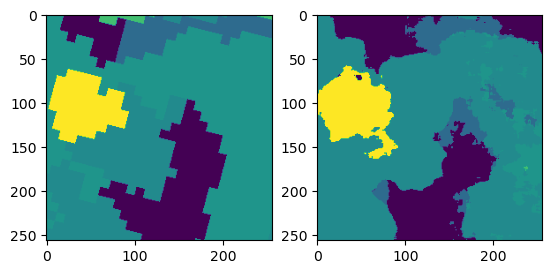

In [13]:
import matplotlib.pyplot as plt
plt.subplot(1,2,1)
plt.imshow(target[2])
print('target unique values',torch.unique(target))
print('predicted unique values',torch.unique(predicted))
plt.subplot(1,2,2)
plt.imshow(predicted.cpu())

In [ ]:
plt.imshow(predicted.squeeze(0).cpu())

In [88]:
labels.shape

torch.Size([4, 1, 256, 256])

In [23]:
labels.shape

torch.Size([4, 1, 256, 256])

In [475]:
len(sum(labels[0,:,:,2] == labels[0,:,:,5]))

512

In [460]:
me = torch.exp(labels.view(-1, 43, 512, 512))
me= torch.argmax(me, 1)
me.shape

torch.Size([10, 512, 512])

In [81]:
m = torch.argmax(torch.exp(predicted[1,:,:,:]), dim=0, keepdim = True)
m.shape

torch.Size([1, 256, 256])

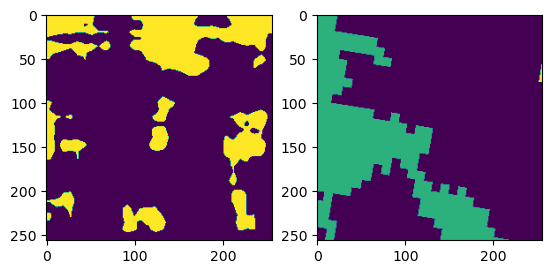

In [105]:

plt.subplot(1,2,1)
plt.imshow(predicted[1].cpu())
plt.subplot(1,2,2)
plt.imshow(labels[1,0].cpu())

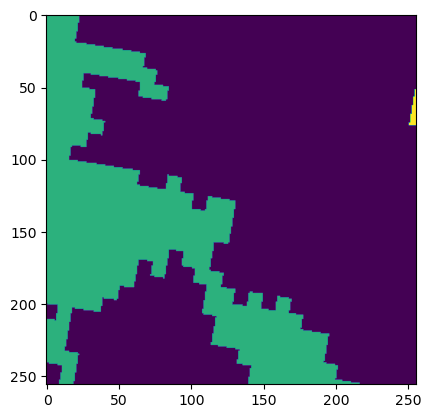

In [104]:
plt.imshow(labels[1,0].cpu())

In [378]:
predicted[0,20].shape

torch.Size([512, 512])

In [128]:
predicted.shape

torch.Size([10, 512, 512])

In [389]:
np.unique(predicted[1].cpu())

array([ 1, 10, 11, 16, 19], dtype=int64)

In [464]:
np.unique(me[1].cpu())

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42], dtype=int64)

## Visualization of results to generate uncertainty maps

In [2]:
# For DeepLabvV3
# Define your Monte Carlo Dropout function
num_samples = 100

def mc_dropout(model, x, num_samples):
    torch.cuda.empty_cache()
    with torch.no_grad():
        model.train()
        x = x.to('cuda')
        #print(x.shape)
        #outputs = torch.zeros((num_samples,) + x.shape[1:])
        # smx = torch.softmax(model(x), dim=1)
        # print(smx.shape)
        # output_classes = torch.argmax(smx, 1)
        preds = [(torch.softmax(model(x)['out'], dim=1).cpu().detach()) for i in range(num_samples)]
        #pred = model(x)['out'].cpu().detach()
        # print('model output is -->',model(x)['out'].shape)
        #preds.append(pred)
        #torch.argmax(torch.softmax(, dim=0), 0)
     
    return preds



# Create an empty tensor to store the outputs


# Create an empty tensor with the desired shape

all_predictions = []
print(len(test_dataloader))
# Loop over the input data
for imgs , target in tqdm(test_dataloader):
    imgs, target = imgs.cuda().float(), target.cuda().squeeze(1)
    # plt.imshow(imgs[0].permute(1,2,0).cpu().detach().numpy())
    batch_predictions = []
    pred_sets = mc_dropout(model, imgs, num_samples)
    img_predictions = torch.stack(pred_sets, dim=1)
    #batch_predictions.append(img_predictions)
    #batch_predictions.append(pred_sets)

    # imgs.cpu().detach()
    # target.cpu().detach()

  
  
    
    #batch_predictions = torch.stack(batch_predictions, dim=0)
    
    all_predictions.append(img_predictions)
    

    
monte_carlo_predictions = torch.cat(all_predictions, dim=0)
print('mc predcs--->',monte_carlo_predictions.shape)
'''# Calculate uncertainty maps
variance = torch.var(outputs, dim=1)  # Variance across the Monte Carlo samples
uncertainty_maps = 1 - torch.max(F.softmax(variance, dim=1), dim=1)[0]  # Uncertainty maps

# Print the shape of the uncertainty maps tensor
print(uncertainty_maps.shape)'''

5


100%|██████████| 5/5 [00:35<00:00,  7.17s/it]


mc predcs---> torch.Size([20, 100, 43, 256, 256])


'# Calculate uncertainty maps\nvariance = torch.var(outputs, dim=1)  # Variance across the Monte Carlo samples\nuncertainty_maps = 1 - torch.max(F.softmax(variance, dim=1), dim=1)[0]  # Uncertainty maps\n\n# Print the shape of the uncertainty maps tensor\nprint(uncertainty_maps.shape)'

In [104]:
imgs.shape

torch.Size([4, 3, 256, 256])

In [125]:
imgs.shape

torch.Size([4, 3, 256, 256])

In [ ]:
for imgs , target in tqdm(test_dataloader):
    imgs, target = imgs.cuda().float(), target.cuda().squeeze(1)
    for i in range(imgs.shape[0]):
        plt.figure(figsize=(10, 10), dpi=600)

        plt.subplot(1, 1, i+1)
        plt.imshow(imgs[i,:].permute(1,2,0).cpu().detach().numpy()*5, cmap='Greens')
        plt.axis('off')
        plt.savefig('Original_input.png', dpi=600)
        break

In [106]:
for param in model.parameters():
    param.requires_grad = False

for module in model.modules():
        # for child in module.children():
    if isinstance(module, nn.Dropout2d):
        print('helw', module)
        module.train(True)

helw Dropout2d(p=0.2, inplace=False)


In [ ]:
# For Unet
num_samples = 5

def mc_dropout(model, x, num_samples):
    torch.cuda.empty_cache()
    with torch.no_grad():
        # model.train()

        for param in model.parameters():
             param.requires_grad = False

        for module in model.modules():
            # for child in module.children():
            if isinstance(module, nn.Dropout2d):
                # print('helw', module)
                module.train(True)
            
        x = x.to('cuda')
        #print(x.shape)
        #outputs = torch.zeros((num_samples,) + x.shape[1:])
        # smx = torch.softmax(model(x), dim=1)
        # print(smx.shape)
        # output_classes = torch.argmax(smx, 1)
        preds = [(torch.softmax(model(x), dim=1).cpu().detach()) for i in range(num_samples)]
        #pred = model(x)['out'].cpu().detach()
        #print('model output is -->',model(x)['out'].size)
        #preds.append(pred)
        #torch.argmax(torch.softmax(, dim=0), 0)
     
    return preds



# Create an empty tensor to store the outputs


# Create an empty tensor with the desired shape

all_predictions = []
print(len(test_dataloader.dataset))
# Loop over the input data
for imgs , target in tqdm(test_dataloader):
    imgs, target = imgs.cuda().float(), target.cuda().squeeze(1)
    batch_predictions = []
    pred_sets = mc_dropout(model, imgs, num_samples)
    img_predictions = torch.stack(pred_sets, dim=1)
    #batch_predictions.append(img_predictions)
    #batch_predictions.append(pred_sets)

    # imgs.cpu().detach()
    # target.cpu().detach()
    
    

  
  
    
    #batch_predictions = torch.stack(batch_predictions, dim=0)
    
    all_predictions.append(img_predictions)
    del pred_sets
    del img_predictions
    

    
monte_carlo_predictions = torch.cat(all_predictions, dim=0).cpu().detach()
print('mc predcs--->',monte_carlo_predictions.shape)
'''# Calculate uncertainty maps
variance = torch.var(outputs, dim=1)  # Variance across the Monte Carlo samples
uncertainty_maps = 1 - torch.max(F.softmax(variance, dim=1), dim=1)[0]  # Uncertainty maps

# Print the shape of the uncertainty maps tensor
print(uncertainty_maps.shape)'''

In [2]:
# For Unet
# In order not to crash the ram system
num_samples = 5
# Create an empty tensor to store the outputs
mc_outputs = torch.empty((batch_size, num_samples, 43, 256, 256))

def mc_dropout(model, x, num_samples):
    """Function to perform Monte Carlo dropout on the input images

    Args:
        model (nn.Module): model to drop out its own parameters
        x (torch.Tensor):  input images, shape -> (batch_size, channels, height, width)
        num_samples (int): sampling number

    Returns:
        mc_outputs (torch.Tensor): Monte Carlo dropout outputs 
        - shape -> (batch_size, num_samples, channels, height, width)
    """
    torch.cuda.empty_cache()
    with torch.no_grad():
        # model.train()

        for param in model.parameters():
             param.requires_grad = False

        for module in model.modules():
            # for child in module.children():
            if isinstance(module, nn.Dropout2d):
                # print('helw', module)
                module.train(True)
            
        x = x.to('cuda')
        #print(x.shape)
        #outputs = torch.zeros((num_samples,) + x.shape[1:])
        # smx = torch.softmax(model(x), dim=1)
        # print(smx.shape)
        # output_classes = torch.argmax(smx, 1)
        # preds = [(torch.softmax(model(x), dim=1).cpu().detach()) for i in range(num_samples)]
        # print(torch.softmax(model(x), dim=1).cpu().detach().shape)
        # print(model(x).shape, torch.softmax(model(x), dim=1).shape)

        # This sum should be equal to one as the softmax is applied to the output across all of the classes at a certain pixel
        # print(sum(torch.softmax(model(x), dim=1)[0, :, 0, 0]))
        for i in range(num_samples):
            # Here we apply the model while using Monte Carlo dropout to get the variation of the results
            mc_outputs[:, i, :, :, :] = torch.softmax(model(x), dim=1).cpu().detach()
        #pred = model(x)['out'].cpu().detach()
        #print('model output is -->',model(x)['out'].size)
        #preds.append(pred)
        #torch.argmax(torch.softmax(, dim=0), 0)
        # print(mc_outputs.shape)
     
    return mc_outputs



# Create an empty tensor to store the outputs


# Create an empty tensor with the desired shape

all_predictions = []
print(len(test_dataloader.dataset))
# Loop over the input data
for imgs , target in tqdm(test_dataloader):
    imgs, target = imgs.cuda().float(), target.cuda().squeeze(1)
    batch_predictions = []
    pred_sets = mc_dropout(model, imgs, num_samples)
    # print(pred_sets.shape)
    # img_predictions = torch.stack(pred_sets, dim=1)
    img_predictions = pred_sets
    #batch_predictions.append(img_predictions)
    #batch_predictions.append(pred_sets)

    # imgs.cpu().detach()
    # target.cpu().detach()
    
    

  
  
    
    #batch_predictions = torch.stack(batch_predictions, dim=0)
    
    all_predictions.append(img_predictions)
    #
    del pred_sets
    del img_predictions
    # del imgs
    

    
monte_carlo_predictions = torch.cat(all_predictions, dim=0)
print('mc predcs--->',monte_carlo_predictions.shape)

10


  0%|          | 0/1 [00:00<?, ?it/s]c:\Users\midok\anaconda3\envs\pyt_gpu\lib\site-packages\torch\nn\modules\conv.py:459: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\Convolution.cpp:1004.)
  return F.conv2d(input, weight, bias, self.stride,
100%|██████████| 1/1 [00:00<00:00,  1.17it/s]

mc predcs---> torch.Size([8, 5, 43, 256, 256])


In [144]:
imgs.shape

torch.Size([8, 10, 256, 256])

In [ ]:
bgrb = model(imgs)[1].view(-1, 256*256)
# (torch.softmax(torch.softmax(model(imgs)[0,:], dim=1), dim=2)[0]).sum(dim=(0))
plt.figure(figsize=(25, 12))
for i in range(43):
    plt.subplot(11, 4, i+1)
    plt.imshow(torch.softmax(bgrb[i], dim=0).view(256, 256).cpu().detach().numpy())

In [ ]:
print([imgx.shape for imgx in pred_sets])


images batch shape is torch.Size([8, 10, 256, 256]) and targets batch shape is torch.Size([8, 1, 256, 256])
image shape is torch.Size([10, 256, 256]) and target shape is torch.Size([1, 256, 256])
output shape is torch.Size([8, 43, 256, 256])
output shape before softmax is torch.Size([43, 256, 256])
output prob shape after sigmoid  is torch.Size([43, 256, 256])
binary_predictions shape after threshold is torch.Size([43, 256, 256])
predictions shape after argmax is torch.Size([256, 256])
preicted classes  tensor([ 1,  2, 11, 19, 21, 22, 23, 25, 27, 30, 34, 38, 39], device='cuda:0')
ground truth classes tensor([ 1, 11, 18, 19, 21, 22, 23, 38])
pred shape, torch.Size([256, 256])
target shape,  torch.Size([256, 256])
iou -----> tensor(46.4302, device='cuda:0')  % 


(-0.5, 255.5, 255.5, -0.5)

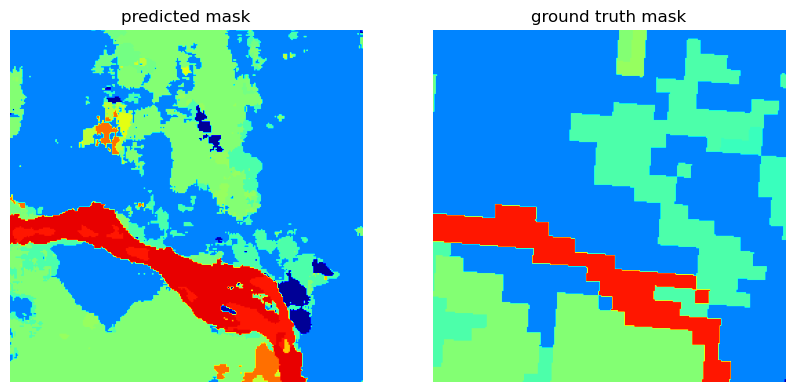

In [4]:
import matplotlib.pyplot as plt

from torch import tensor
from torchmetrics.functional.classification import multiclass_jaccard_index, multilabel_jaccard_index
images, targets = next(iter(dataloader))
print(f'images batch shape is {images.shape} and targets batch shape is {targets.shape}')
image, target = images[0], targets[0]
print(f'image shape is {image.shape} and target shape is {target.shape}')


input_tensor = images.float().cuda()
input_tensor
model.eval()
# Make predictions

with torch.no_grad():
        outputs = model(input_tensor)
    
print(f'output shape is {outputs.shape}')
output = outputs[0]
print(f'output shape before softmax is {output.shape}')# .detach().cpu().numpy()
target = target[0]#.detach().cpu().numpy()
output_prob = torch.sigmoid(output)

print(f'output prob shape after sigmoid  is {output_prob.shape}')

#binary_predictions = (output_prob > 0.5).cpu().numpy().astype(int)
print(f'binary_predictions shape after threshold is {output_prob.shape}')

prediction = torch.argmax(output_prob, dim = 0)
print(f'predictions shape after argmax is {prediction.shape}')





target = target.long()

preds = prediction.long()

print('preicted classes ',torch.unique(preds))
print('ground truth classes',torch.unique(target))
print('pred shape,',preds.shape)
print('target shape, ', target.shape)
print('iou ----->',multiclass_jaccard_index(preds, target.cuda(), num_classes= 43, average='weighted')*100, ' % ')




# Visualize the original image and predicted mask
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[1].imshow(target, cmap='jet', vmin=0, vmax=43)  
axs[1].set_title('ground truth mask')
axs[1].axis('off')

axs[0].imshow(prediction.cpu(), cmap='jet', vmin=0, vmax=43)
axs[0].set_title('predicted mask')
axs[0].axis('off')




In [8]:
monte_carlo_predictions.shape

torch.Size([20, 3, 43, 256, 256])

In [137]:
(monte_carlo_predictions[0, 0, 22]/torch.max(monte_carlo_predictions[0, 0, 22]))

tensor([[0.2775, 0.1876, 0.2105,  ..., 0.2606, 0.2567, 0.3254],
        [0.2128, 0.1592, 0.1506,  ..., 0.3043, 0.3006, 0.2640],
        [0.2221, 0.1889, 0.1897,  ..., 0.4034, 0.3643, 0.2694],
        ...,
        [0.7933, 0.7830, 0.7455,  ..., 0.8157, 0.8156, 0.8173],
        [0.7990, 0.7988, 0.7488,  ..., 0.7696, 0.7951, 0.7735],
        [0.7435, 0.7677, 0.7330,  ..., 0.7813, 0.7915, 0.7366]])

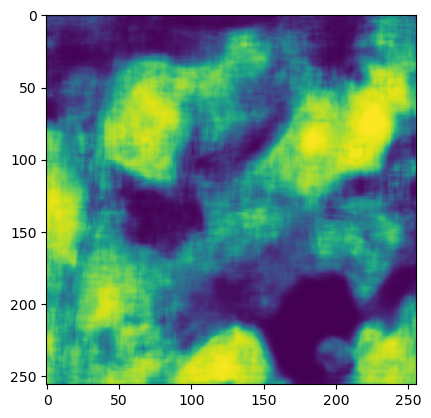

In [135]:
plt.imshow(monte_carlo_predictions[0, 0, 22]/torch.max(monte_carlo_predictions[0, 0, 22]))

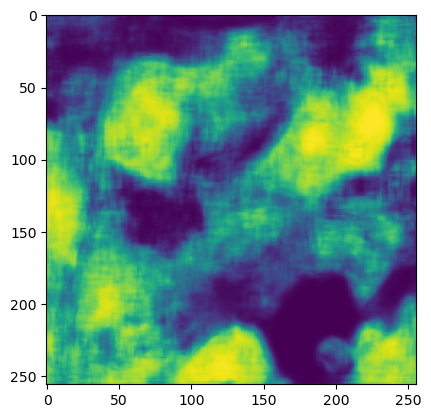

In [136]:
plt.imshow(monte_carlo_predictions[0, 0, 22])

IndexError: index 3 is out of bounds for dimension 1 with size 3

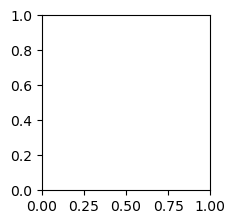

In [65]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))

for i in range(imgs.size(0)):
    plt.subplot(2, 4, i+1)
    plt.imshow(imgs[i,3,:,:].cpu())

In [27]:
last_imgs = monte_carlo_predictions[:, :,:,:,:]
last_imgs.shape

torch.Size([8, 5, 43, 256, 256])

In [28]:
var_img_last = last_imgs[:, :, :, :, :].std(dim=1)
var_img_last.shape

torch.Size([8, 43, 256, 256])

In [49]:
mean_img_last = last_imgs[:, :, :, :, :].mean(dim=1)
mean_img_last.shape

torch.Size([8, 43, 256, 256])

In [50]:
entropy_img_last = -torch.sum(mean_img_last*  torch.log2(mean_img_last + 1e-10), dim=1)
entropy_img_last.shape

torch.Size([8, 256, 256])

In [23]:
last_imgs.shape

torch.Size([8, 5, 43, 256, 256])

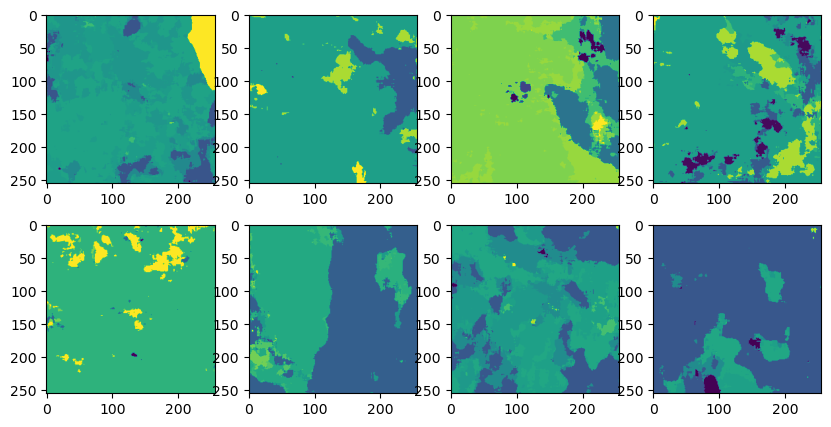

In [46]:
plt.figure(figsize=(10, 5))

for i in range(imgs.size(0)):
    plt.subplot(2, 4, i+1)
    plt.imshow(last_imgs[i, 4, :  :, :].argmax(dim=0).cpu())
    

In [37]:
target.shape

torch.Size([8, 256, 256])

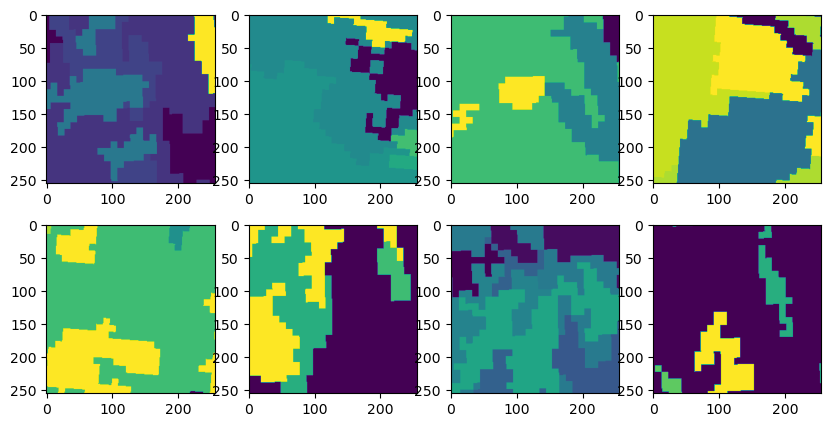

In [47]:
plt.figure(figsize=(10, 5))

for i in range(imgs.size(0)):
    plt.subplot(2, 4, i+1)
    plt.imshow(target[i,  :, :].cpu())

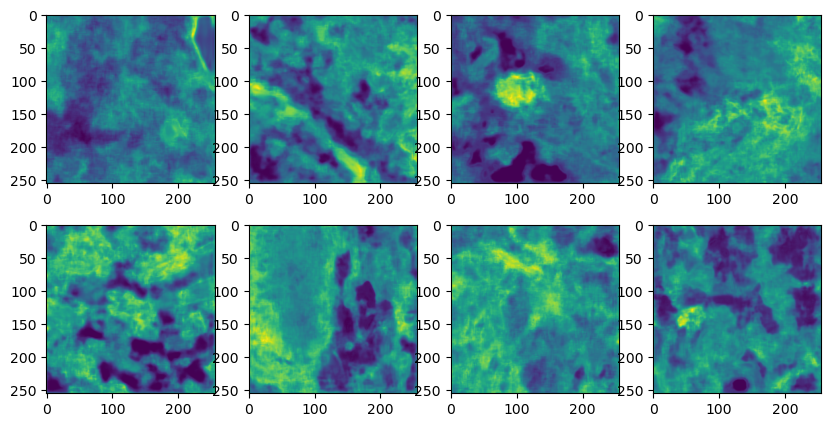

In [51]:
plt.figure(figsize=(10, 5))

for i in range(imgs.size(0)):
    plt.subplot(2, 4, i+1)
    plt.imshow(entropy_img_last[i , :, :].cpu())

In [3]:
monte_carlo_predictions.shape

torch.Size([20, 100, 43, 256, 256])

In [4]:
var_img = monte_carlo_predictions[:, :, :, :, :].std(dim=1)
var_img.shape

torch.Size([20, 43, 256, 256])

In [9]:
mean_var = var_img.sum(dim=(2,3))
mean_var.shape

torch.Size([20, 43])

In [5]:
mean_img = monte_carlo_predictions[:, :, :, :, :].mean(dim=1)
mean_img.shape

torch.Size([20, 43, 256, 256])

In [ ]:
def pixel_entropy(images):
    # Convert the pixel values to probabilities (normalize to sum to 1)
    # probabilities = F.softmax(images, dim=1)

    # Compute the entropy for each pixel
    entropy = -torch.sum(probabilities * torch.log2(probabilities + 1e-10), dim=1)  # Add a small value to avoid log(0)

    return entropy

In [80]:
def segmentation_uncertainty(mc_predictions, dimension, entrpoy_dim ,normalized = True):
    """Function to calculate the measures for uncertainty (mean, variance, entropy).

    :param: mc_preictions: torch tensor including the outputs from Monte Carlo outputs, type (np.array or torch.Tensor).
    Shape:
    - (b,r,c,h,w)
    - b -> batch size
    - r -> Monte Carlo number of runs
    - c -> number of classes(channels)
    - h -> height of the image
    - w -> width of the image

    :param: dimension: the dimension on which we want to get the estimate.

    :param: entropy_dimension: the dimension on which we want to calculate the entropy.
    - entrpoy_dim = 1 -> on the monte carlo access (across the models)
    - entropy_dim = 2 -> on the channels dimesnions (across the classes)

    :param: normalized: if entropy is required to be in range (0~1).

    

    :return: variance, mean, entropy, type(np.array or torch.Tensor)
    """

    mean_mc = mc_predictions.mean(dim=dimension)
    std_mc = mc_predictions.std(dim=dimension)

    
    entropy_mc = -torch.sum(mc_predictions*  torch.log2(mc_predictions + 1e-10), dim=entrpoy_dim)

    if normalized:
        entropy_mc = entropy_mc / np.log2(mc_predictions.size(2))
    

    return mean_mc, std_mc, entropy_mc

In [ ]:
mc_predictions = monte_carlo_predictions
dimension = 1
entropy_dim = 1

mean_mc, std_mc, entropy_mc = segmentation_uncertainty(mc_predictions, dimension=dimension, entrpoy_dim=entropy_dim)
print(mean_mc.shape, std_mc.shape, entropy_mc.shape)

In [150]:
normalized = True
print(not normalized)

False


In [6]:
mean_img.shape

torch.Size([20, 43, 256, 256])

In [4]:
monte_carlo_predictions.shape

torch.Size([20, 100, 43, 256, 256])

In [5]:
fina_models_pred = torch.argmax(monte_carlo_predictions[:, :, :, :, :], dim=2)

In [6]:
final_models_pred = fina_models_pred.float()
final_models_pred.shape

torch.Size([20, 100, 256, 256])

In [103]:
fina

tensor([[11, 11, 11,  ..., 21, 21, 21],
        [11, 11, 11,  ..., 21, 21, 21],
        [11, 11, 11,  ..., 21, 21, 21],
        ...,
        [23, 23, 23,  ..., 39, 39, 39],
        [23, 23, 23,  ..., 39, 39, 39],
        [23, 23, 23,  ..., 39, 39, 39]])

In [7]:
std_img = final_models_pred.std(dim=1)
std_img.shape

torch.Size([20, 256, 256])

In [ ]:
plt.figure(figsize=(10,8))
plt.figure(dpi=600)
for i in range(1):

    
    plt.subplot(1,1, i+1)
    plt.imshow(torch.argmax(monte_carlo_predictions[0, 99, :, :,:], dim=0))
    plt.axis('off')
    plt.grid()
    # plt.title(str(i))
    # plt.colorbar()
    plt.savefig('Prediction_model99.png', dpi=600)

In [77]:
len(test_dataloader.dataset)

20

In [ ]:
temp = []
for batch in test_dataloader:
    imgs, _ = batch
    for i in range(len(imgs)):
        plt.figure(figsize=(10,8))
        plt.figure(dpi=600)
        plt.subplot(1, 4, i+1)
        plt.imshow(imgs[i].permute(1,2,0)*2)
        temp.append(imgs[i])

        # plt.axes('off')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

<Figure size 2000x1600 with 0 Axes>

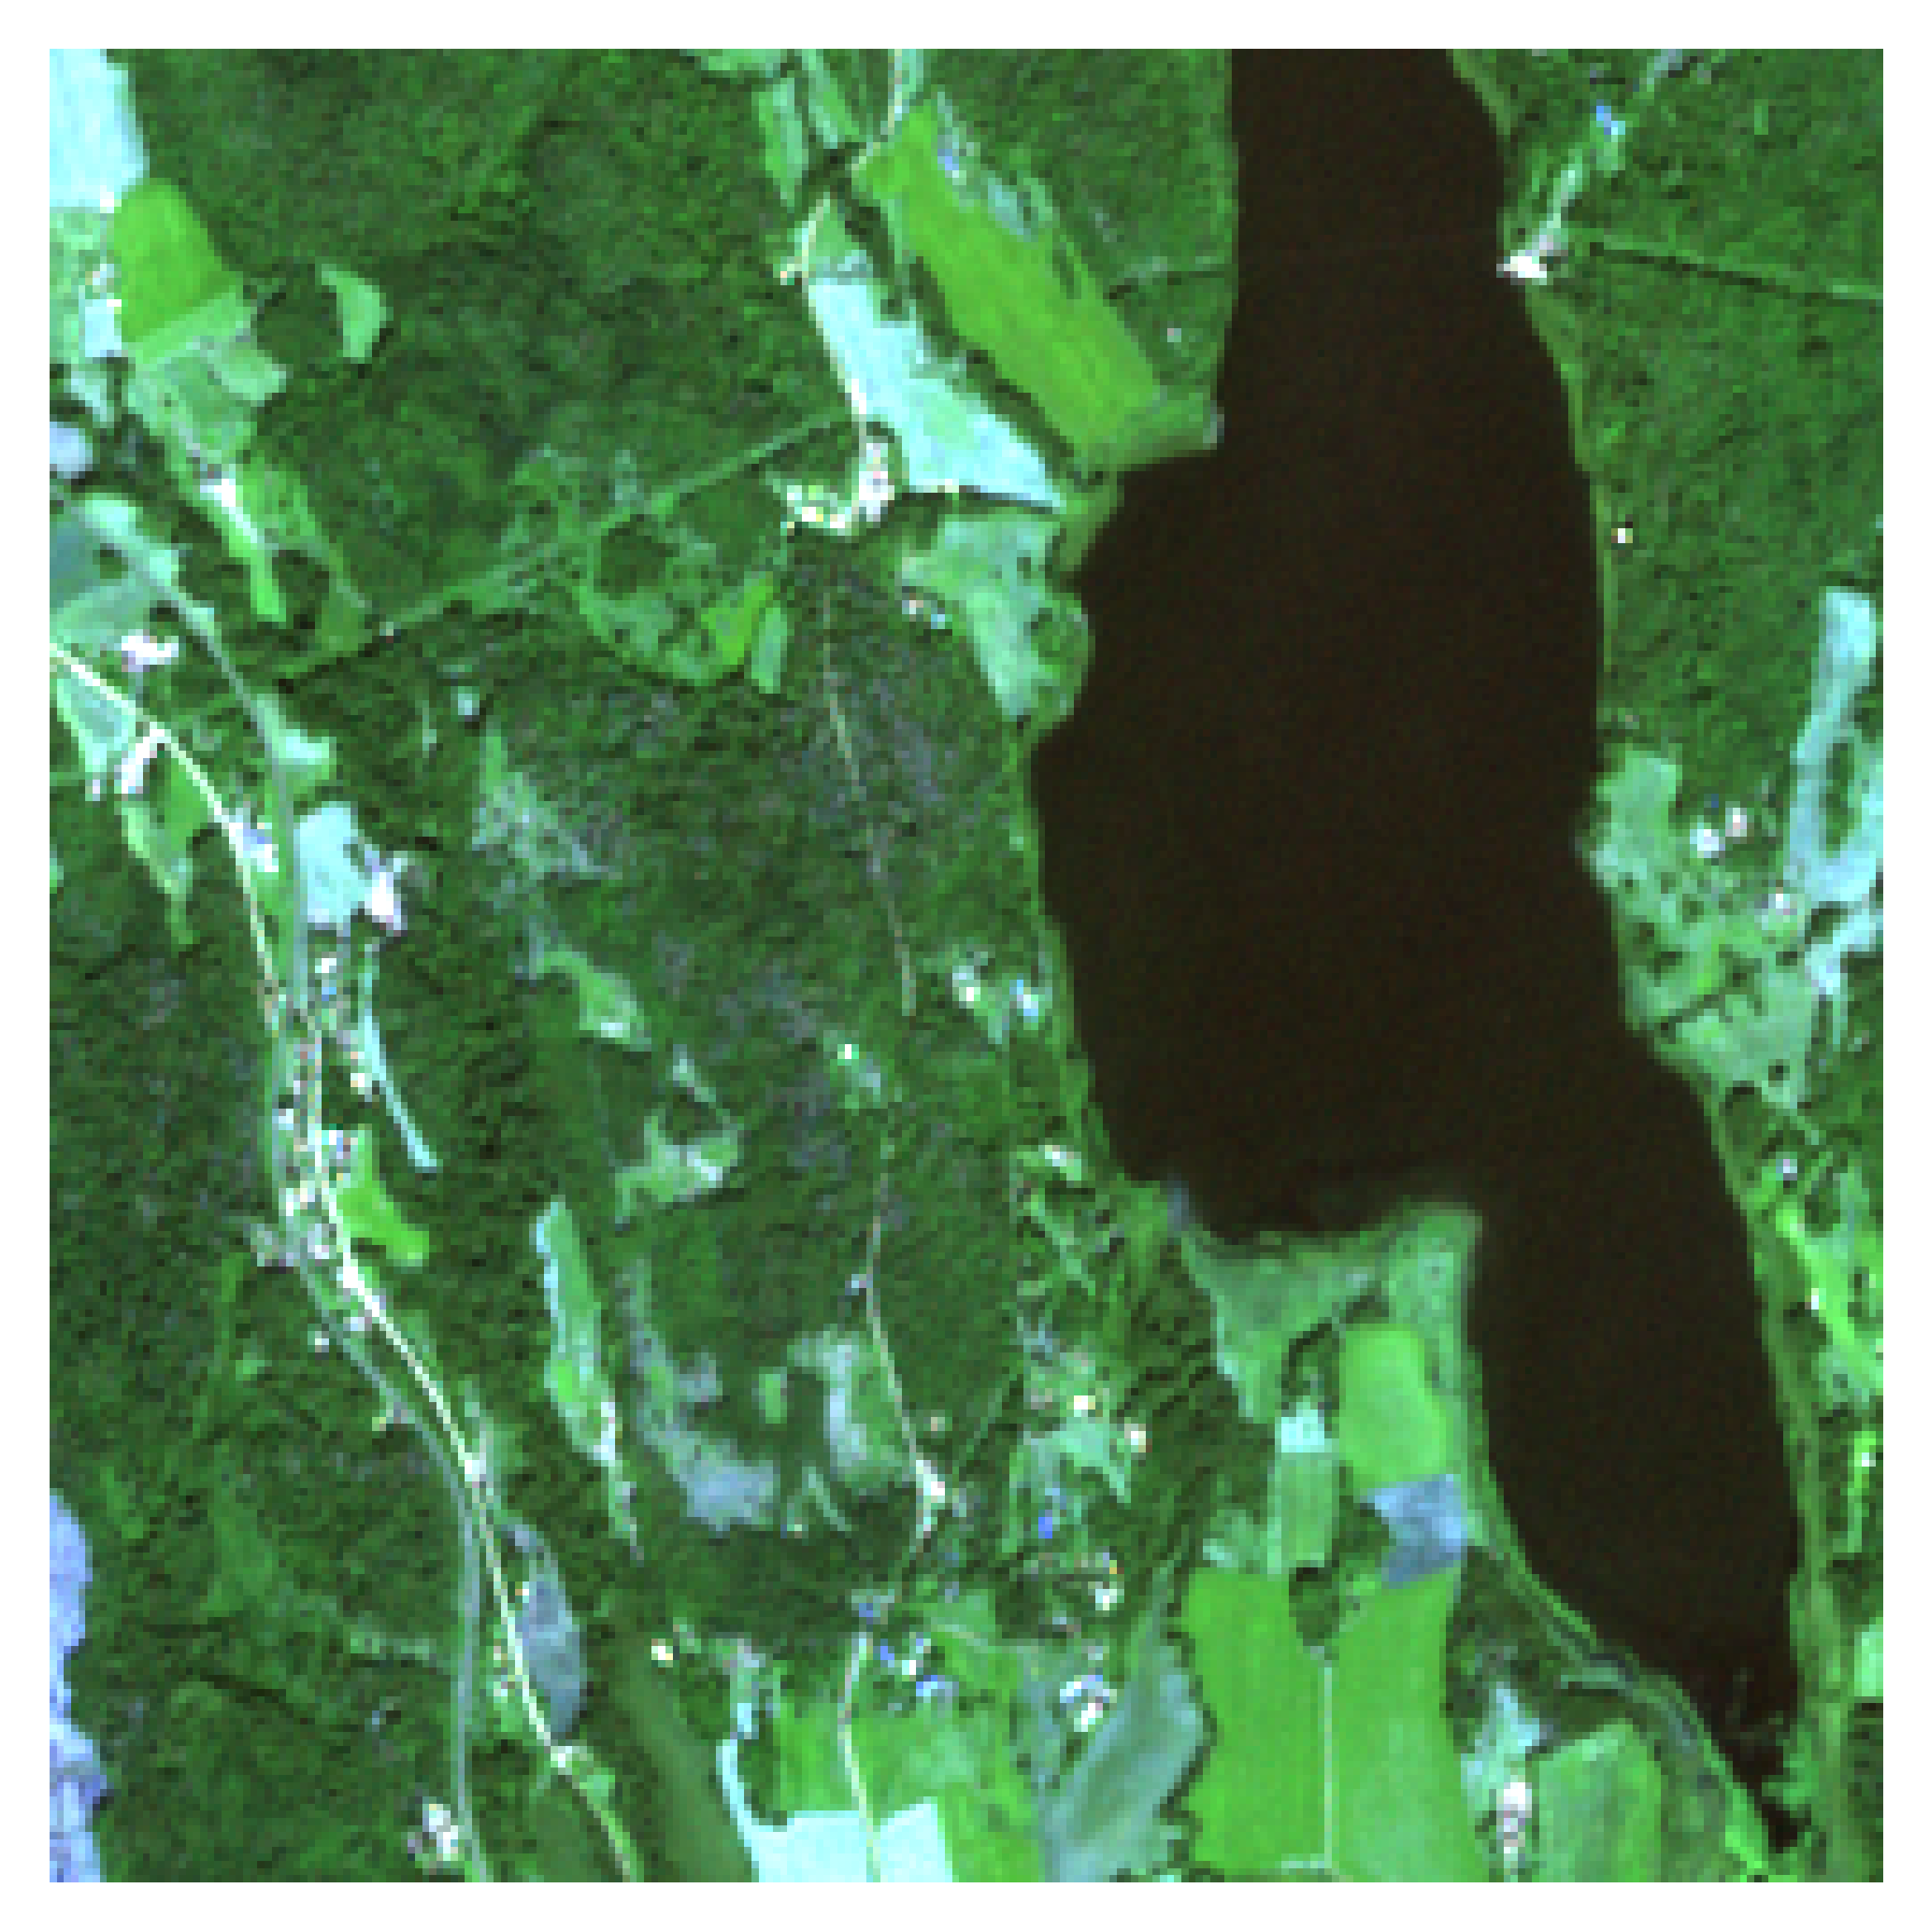

In [130]:
plt.figure(figsize=(20,16))
plt.figure(dpi=600)
for i in range(len(temp)):
    
    plt.subplot(1, 1, 1)
    plt.imshow(temp[0].permute(1,2,0)*11)
    plt.axis('off')
    # plt.title(f'{i}')

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
plt.figure(figsize=(10,8))
plt.figure(dpi=600)

# Load images
# image1 = mpimg.imread('image1.png')
# image2 = mpimg.imread('image2.png')

# Overlay images using plt.imshow()

cmap1 = 'viridis'  # Choose an appropriate colormap for image1
cmap2 = 'Greys_r'

plt.imshow(torch.argmax(monte_carlo_predictions[0, 0, :, :,:], dim=0), cmap=cmap1)
plt.imshow(std_img[0]*2, alpha=0.5, cmap=cmap2)  # Overlay with transparency


# Show the overlaid image
plt.axis('off')  # Turn off axis ticks and labels
# plt.show()
# plt.savefig('uncertainty_map_overlaid.png', dpi=600)


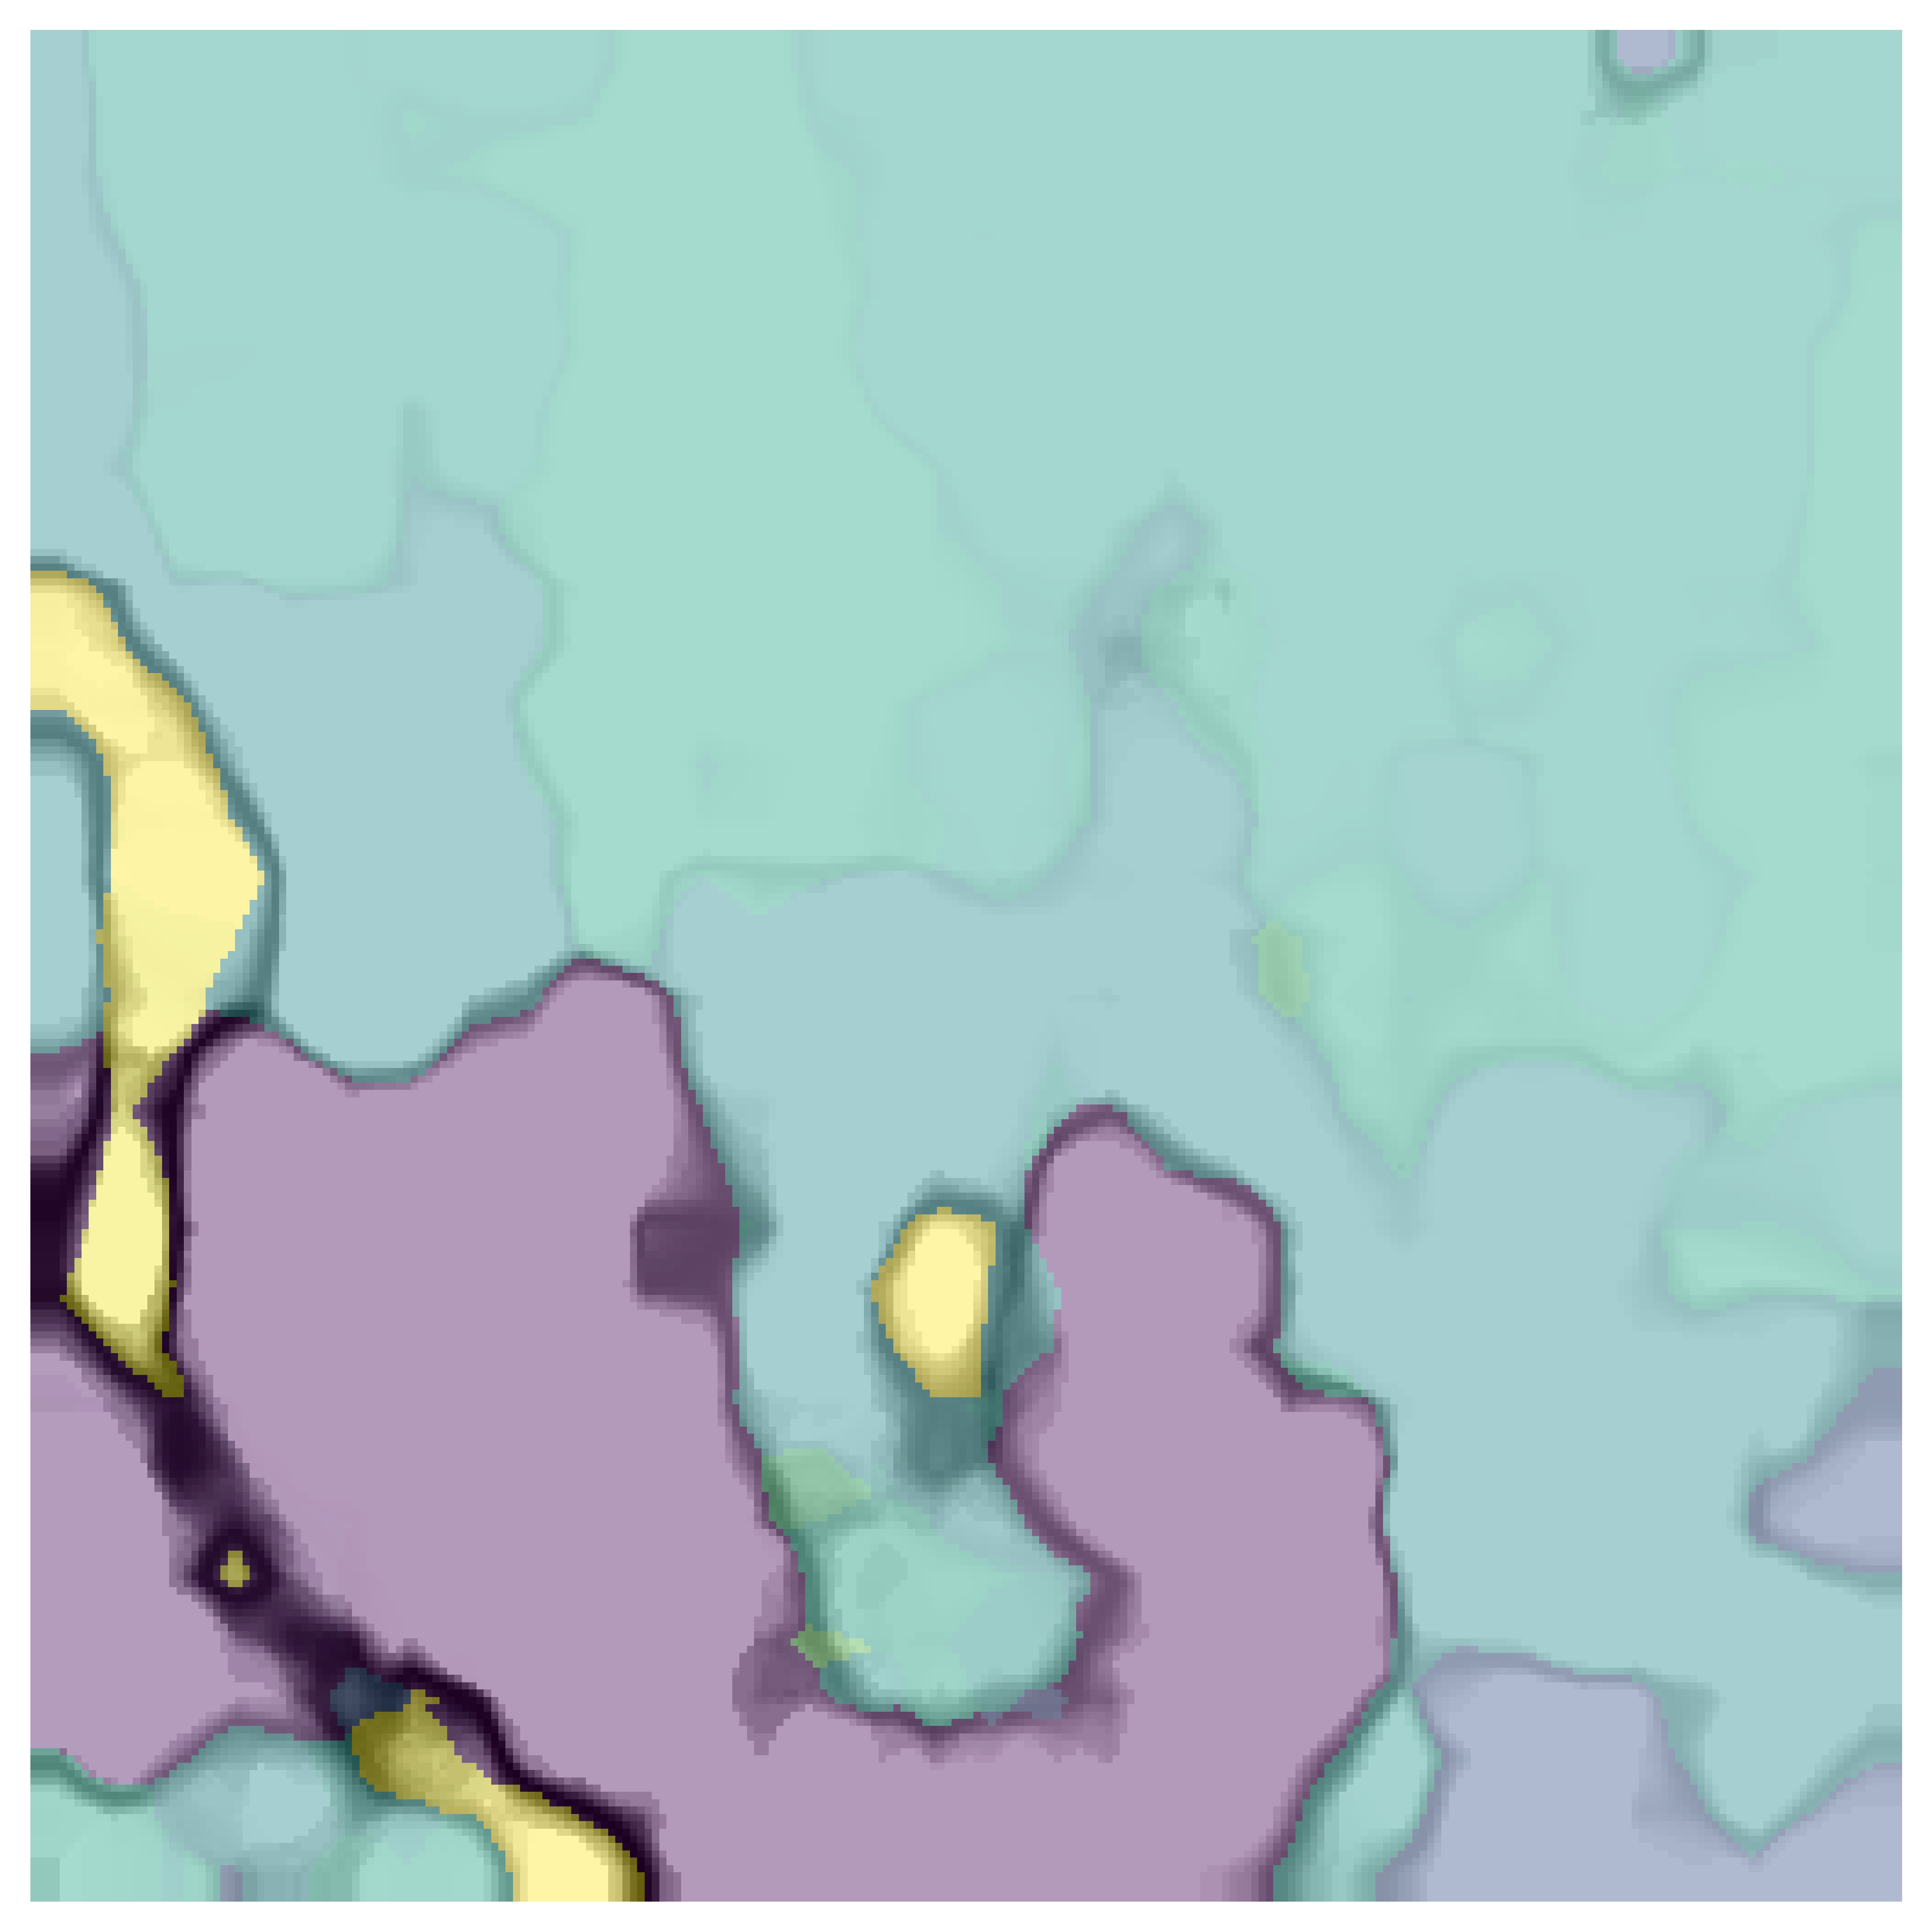

In [124]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import ListedColormap
import torch

# Create custom colormaps
cmap1_colors = plt.cm.viridis(np.linspace(0, 1, 256))  # Replace with your desired colormap
cmap1 = ListedColormap(cmap1_colors)

cmap2_colors = plt.cm.binary(np.linspace(0, 1, 256) )  # Adjust the alpha value as needed
cmap2 = ListedColormap(cmap2_colors)

plt.figure(figsize=(10, 8), dpi=600)

# Assuming you have defined monte_carlo_predictions and std_img elsewhere in your code
plt.imshow(torch.argmax(monte_carlo_predictions[8, 0, :, :, :], dim=0), cmap=cmap1)
plt.imshow(std_img[8] , alpha=0.6, cmap=cmap2)

# Show the overlaid image
plt.axis('off')

# Create colorbars for the custom colormaps
# cbar1 = plt.colorbar(plt.cm.ScalarMappable(cmap=cmap1))
# cbar1.set_label('Custom Colormap 1')

# cbar2 = plt.colorbar(plt.cm.ScalarMappable(cmap=cmap2))
# cbar2.set_label('Pixel Uncertainty')

plt.savefig('uncertainty_map_overlaid_with_color_map.pdf', dpi=600)
plt.show()


In [91]:
import os
os.getcwd()

'c:\\Users\\midok\\OneDrive\\Desktop\\Imam_farag_paper'

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,8))
plt.figure(dpi=600)

for i in range(1):
    
    plt.subplot(1,1, i+1)
    plt.imshow(std_img[i]/14, cmap='Greys_r')
    plt.axis('off')
    plt.grid()
    # plt.title(str(i))
    # plt.colorbar()
    plt.savefig('uncertainty_image.png', dpi=600)

In [ ]:
plt.figure(figsize=(10,8))
plt.figure(dpi=600)
for i in range(1):
    
    plt.subplot(1,1, i+1)
    plt.imshow(fina_models_pred[i,0], cmap='crest')
    plt.savefig('original_output.png', dpi=600)

In [21]:
entropy_img = -torch.sum(monte_carlo_predictions[2,1,:,:,:]*  torch.log2(monte_carlo_predictions[0,0,:,:,:] + 1e-10), dim=0)
entropy_img.shape

torch.Size([256, 256])

In [12]:
cmap_list = ['Accent', 'Accent_r', 'Blues', 'Blues_r', 'BrBG', 'BrBG_r', 'BuGn', 'BuGn_r', 'BuPu', 'BuPu_r', 
'CMRmap', 'CMRmap_r', 'Dark2', 'Dark2_r', 'GnBu', 'GnBu_r', 'Greens', 'Greens_r', 'Greys', 'Greys_r', 'OrRd', 'OrRd_r', 'Oranges', 'Oranges_r', 'PRGn', 'PRGn_r', 
'Paired', 'Paired_r', 'Pastel1', 'Pastel1_r', 'Pastel2', 'Pastel2_r', 'PiYG', 'PiYG_r', 'PuBu', 'PuBuGn', 'PuBuGn_r', 'PuBu_r', 'PuOr', 'PuOr_r', 'PuRd', 'PuRd_r', 
'Purples', 'Purples_r', 'RdBu', 'RdBu_r', 'RdGy', 'RdGy_r', 'RdPu', 'RdPu_r', 'RdYlBu', 'RdYlBu_r', 'RdYlGn', 'RdYlGn_r', 'Reds', 'Reds_r', 'Set1', 'Set1_r', 'Set2', 
'Set2_r', 'Set3', 'Set3_r', 'Spectral', 'Spectral_r', 'Wistia', 'Wistia_r', 'YlGn', 'YlGnBu', 'YlGnBu_r', 'YlGn_r', 'YlOrBr', 'YlOrBr_r', 'YlOrRd', 'YlOrRd_r', 'afmhot', 
'afmhot_r', 'autumn', 'autumn_r', 'binary', 'binary_r', 'bone', 'bone_r', 'brg', 'brg_r', 'bwr', 'bwr_r', 'cividis', 'cividis_r', 'cool', 'cool_r', 'coolwarm', 'coolwarm_r', 
'copper', 'copper_r', 'crest', 'crest_r', 'cubehelix', 'cubehelix_r', 'flag', 'flag_r', 'flare', 'flare_r', 'gist_earth', 'gist_earth_r', 'gist_gray', 'gist_gray_r', 'gist_heat', 
'gist_heat_r', 'gist_ncar', 'gist_ncar_r', 'gist_rainbow', 'gist_rainbow_r', 'gist_stern', 'gist_stern_r', 'gist_yarg', 'gist_yarg_r', 'gnuplot', 'gnuplot2', 'gnuplot2_r', 'gnuplot_r', 
'gray', 'gray_r', 'hot', 'hot_r', 'hsv', 'hsv_r', 'icefire', 'icefire_r', 'inferno', 'inferno_r', 'jet', 'jet_r', 'magma', 'magma_r', 'mako', 'mako_r', 'nipy_spectral', 'nipy_spectral_r', 
'ocean', 'ocean_r', 'pink', 'pink_r', 'plasma', 'plasma_r', 'prism', 'prism_r', 'rainbow', 'rainbow_r', 'rocket', 'rocket_r', 'seismic', 'seismic_r', 'spring', 'spring_r', 'summer', 'summer_r', 
'tab10', 'tab10_r', 'tab20', 'tab20_r', 'tab20b', 'tab20b_r', 'tab20c', 'tab20c_r', 'terrain', 
'terrain_r', 'turbo', 'turbo_r', 'twilight', 'twilight_r', 'twilight_shifted', 'twilight_shifted_r', 'viridis', 'viridis_r', 'vlag', 'vlag_r', 'winter', 'winter_r']

In [59]:
len(cmap_list)

178

In [76]:
178/18


9.88888888888889

In [ ]:
sns.imshow(entropy_img, cmap= cmap_list[i], interpolation ='bilinear' )

<Figure size 1000x1000 with 0 Axes>

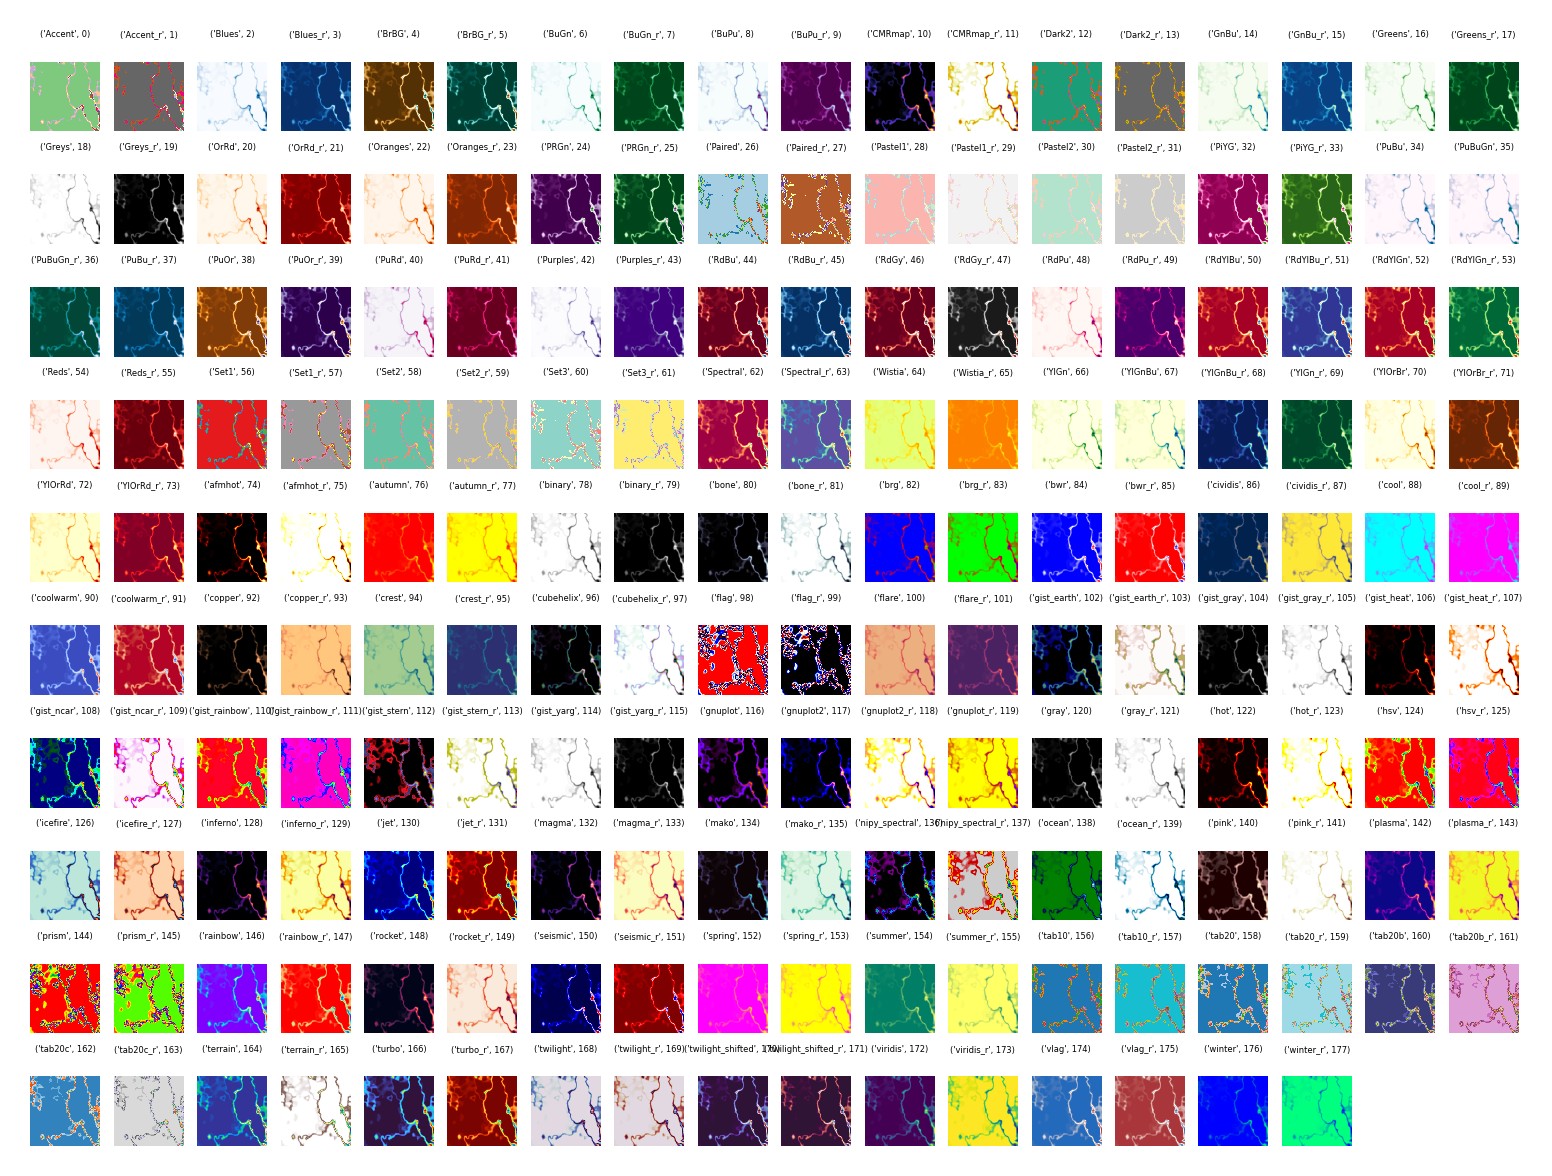

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt
# sns.set(style="ticks")
plt.figure(figsize=(10, 10))
plt.figure(dpi=300)
for i in range(len(cmap_list)):
    plt.subplot(10, 18, i+1)
    plt.imshow(std_img[0] , cmap= cmap_list[i], interpolation ='bilinear' )
    plt.axis('off')
    plt.title(f'{cmap_list[i], i}', fontsize = 2)



In [83]:
np.std([0.33, 0.33, 0.33])

0.0

In [67]:
torch.cuda.empty_cache()
entropy_img = -torch.sum(mean_img*  torch.log2(mean_img + 1e-10), dim=(2,3))
entropy_img.shape

torch.Size([8, 43])

In [68]:
entropy_img[:,:,:,:].std(dim=0).shape

torch.Size([100, 256, 256])

In [87]:
monte_carlo_predictions[2,20,:,:,:].mean(dim=0).shape

torch.Size([256, 256])

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(50,50))
for i in range(monte_carlo_predictions.size(1)):
    plt.subplot(10, 10, i+1)
    plt.imshow(entropy_img[10,i,:,:]/np.log2(43))
    plt.title(f"Model{i+1}")
    # plt.colorbar()

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(entropy_img[10,:,:,:].std(dim=0)/np.log2(43))
plt.colorbar()

In [ ]:
mean_img_across_classes = monte_carlo_predictions[:, :, :, :, :].mean(dim=(1))
mean_img_across_classes.shape

In [ ]:
plt.imshow((entropy_img[0,0,:,:]/np.log2(num_classes)) - mean_img_across_classes[0,0,:,:])
plt.colorbar()

In [ ]:
plt.imshow(mean_img_across_classes[0,0,:,:])
plt.colorbar()

In [ ]:
plt.figure(figsize=(50, 50))
for i in range(monte_carlo_predictions.size(2)):
    plt.subplot(11, 4, i+1)

    plt.imshow(mean_img[0, 0, i, :, :] , cmap='gist_gray')

    # plt.subplot(1, 3, 2)

    # plt.imshow(torch.exp(monte_carlo_predictions[2, 1, 30, :, :]), )

    # plt.subplot(1, 3, 3)

    # plt.imshow(torch.exp(monte_carlo_predictions[2, 2, 30, :, :]), )
    cbar1 = plt.colorbar()
    plt.axis('off')
    plt.tight_layout()

In [ ]:
plt.figure(figsize=(25, 25), dpi=600)


for i in range(monte_carlo_predictions.size(2)):
    plt.subplot(11, 4, i+1)

    plt.imshow(monte_carlo_predictions[1, 0, i, :, :])

    # plt.subplot(1, 3, 2)

    # plt.imshow(torch.exp(monte_carlo_predictions[2, 1, 30, :, :]), )

    # plt.subplot(1, 3, 3)

    # plt.imshow(torch.exp(monte_carlo_predictions[2, 2, 30, :, :]), )
    # cbar1 = plt.colorbar()
    plt.title(str(i))
    plt.axis('off')
    # plt.savefig('class_2_modeln_imagen.png', dpi=600)
    plt.tight_layout()

In [176]:
plt.figure(figsize=(25, 25), dpi=600)


# for i in range(1):
    # plt.subplot(11, 4, i+1)

plt.imshow(monte_carlo_predictions[1, 99, 25, :, :])

# plt.subplot(1, 3, 2)

# plt.imshow(torch.exp(monte_carlo_predictions[2, 1, 30, :, :]), )

# plt.subplot(1, 3, 3)

# plt.imshow(torch.exp(monte_carlo_predictions[2, 2, 30, :, :]), )
# cbar1 = plt.colorbar()
# plt.title(str(i))
plt.axis('off')
plt.savefig('class_25_modeln_image1.png', dpi=600)
plt.tight_layout()

: 

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(50, 50))


for i in range(monte_carlo_predictions.size(2)):
    plt.subplot(11, 4, i+1)

    plt.imshow(var_img[0, 0, i, :, :] , cmap='inferno')

    # plt.subplot(1, 3, 2)

    # plt.imshow(torch.exp(monte_carlo_predictions[2, 1, 30, :, :]), )

    # plt.subplot(1, 3, 3)

    # plt.imshow(torch.exp(monte_carlo_predictions[2, 2, 30, :, :]), )
    # cbar1 = plt.colorbar()
    plt.axis('off')
    plt.tight_layout()
    

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(50, 50))


for i in range(monte_carlo_predictions.size(2)):
    plt.subplot(11, 4, i+1)

    plt.imshow(torch.abs(mean_img[0, 0, i, :, :] - entropy_img[0, i, :, :]) , cmap='gist_gray')

    # plt.subplot(1, 3, 2)

    # plt.imshow(torch.exp(monte_carlo_predictions[2, 1, 30, :, :]), )

    # plt.subplot(1, 3, 3)

    # plt.imshow(torch.exp(monte_carlo_predictions[2, 2, 30, :, :]), )
    cbar1 = plt.colorbar()
    plt.axis('off')
    plt.tight_layout()

In [ ]:
plt.figure(figsize=(50, 50))


for i in range(monte_carlo_predictions.size(2)):
    plt.subplot(11, 4, i+1)

    plt.imshow(entropy_img[10, i, :, :]/np.log2(43) , cmap='inferno')

    # plt.subplot(1, 3, 2)

    # plt.imshow(torch.exp(monte_carlo_predictions[2, 1, 30, :, :]), )

    # plt.subplot(1, 3, 3)

    # plt.imshow(torch.exp(monte_carlo_predictions[2, 2, 30, :, :]), )
    # cbar1 = plt.colorbar()
    plt.title(f'100 models entropy, class {i}')
    plt.axis('off')
    plt.tight_layout()

In [191]:
testing = torch.Tensor([0.2, 0.2, 0.2, 0.2, 0.2])
torch.sum(testing*  torch.log2(testing + 1e-10), dim=0)

tensor(-2.3219)

In [199]:
-(0.000000000000000001*np.log2(0.000000000000001) + 1*np.log2(1))

4.982892142331044e-17

In [200]:
np.log2(43)

5.426264754702098

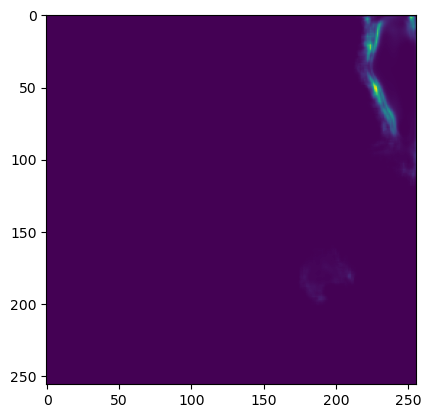

In [133]:
plt.imshow(entropy_img[10, 40, :, :])

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming you have two images, 'image1' and 'image2'

# Define the colormaps for each image
cmap1 = 'inferno'   # Colormap for image1
cmap2 = 'inferno'    # Colormap for image2
plt.figure(figsize=(24,28))
for i in range(monte_carlo_predictions.size(2)):

    image1 = var_img[5, 0, i, :, :]
    image2 = entropy_img[5, i, :, :]/np.log2(num_classes)

    # Normalize the pixel values for each image to [0, 1]
    image1_norm = (image1 - image1.min()) / (image1.max() - image1.min())
    image2_norm = (image2 - image2.min()) / (image2.max() - image2.min())

    # Create a figure and axis to plot the images
    fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True)

    # Display 'image1' with 'cmap1'
    im1 = ax1.imshow(image1_norm, cmap=cmap1)

    # Display 'image2' with 'cmap2' and set alpha (transparency) to blend the images
    # im2 = ax.imshow(image2_norm*1.2, cmap=cmap2, alpha=0.65)  # You can adjust alpha as needed for blending
    im2 = ax2.imshow(image2_norm, cmap=cmap2)
    # Add colorbars for each image
    cbar1 = plt.colorbar(im1, ax=ax1)
    cbar2 = plt.colorbar(im2, ax=ax2)

    # Optionally, you can set labels for the colorbars
    plt.title(f'Class {i}')
    cbar1.set_label('Model output pixel intensity')
    cbar2.set_label('Pixel Uncertainty (entropy)')
    

    # Show the plot

    plt.show()


In [ ]:
plt.imshow(entropy_img[0,:,:,:].mean(dim=0))

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(50, 50))


for i in range(monte_carlo_predictions.size(2)):
    plt.subplot(11, 4, i+1)

    plt.imshow(mean_img[0, 0, i, :, :])

    # plt.subplot(1, 3, 2)

    # plt.imshow(torch.exp(monte_carlo_predictions[2, 1, 30, :, :]), )

    # plt.subplot(1, 3, 3)

    # plt.imshow(torch.exp(monte_carlo_predictions[2, 2, 30, :, :]), )
    plt.axis('off')
    plt.tight_layout()
    

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(50, 50))


for i in range(monte_carlo_predictions.size(2)):
    plt.subplot(11, 4, i+1)

    plt.imshow(entropy_img[0,  i, :, :], cmap='gist_gray')

    # plt.subplot(1, 3, 2)

    # plt.imshow(torch.exp(monte_carlo_predictions[2, 1, 30, :, :]), )

    # plt.subplot(1, 3, 3)

    # plt.imshow(torch.exp(monte_carlo_predictions[2, 2, 30, :, :]), )
    plt.axis('off')
    plt.tight_layout()

In [ ]:
plt.figure(figsize=(50, 50))


for i in range(monte_carlo_predictions.size(2)):
    plt.subplot(11, 4, i+1)

    plt.imshow(monte_carlo_predictions[0, 0, i, :, :])

    # plt.subplot(1, 3, 2)

    # plt.imshow(torch.exp(monte_carlo_predictions[2, 1, 30, :, :]), )

    # plt.subplot(1, 3, 3)

    # plt.imshow(torch.exp(monte_carlo_predictions[2, 2, 30, :, :]), )
    plt.axis('off')
    plt.tight_layout()

In [ ]:
plt.figure(figsize=(50, 50))


for i in range(monte_carlo_predictions.size(2)):
    plt.subplot(11, 4, i+1)

    plt.imshow(monte_carlo_predictions[0, 1, i, :, :])

    # plt.subplot(1, 3, 2)

    # plt.imshow(torch.exp(monte_carlo_predictions[2, 1, 30, :, :]), )

    # plt.subplot(1, 3, 3)

    # plt.imshow(torch.exp(monte_carlo_predictions[2, 2, 30, :, :]), )
    plt.axis('off')
    plt.tight_layout()

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(50, 50))


for i in range(monte_carlo_predictions.size(2)):
    plt.subplot(11, 4, i+1)

    plt.imshow(torch.exp(monte_carlo_predictions[2, 2, i, :, :]), )

    # plt.subplot(1, 3, 2)

    # plt.imshow(torch.exp(monte_carlo_predictions[2, 1, 30, :, :]), )

    # plt.subplot(1, 3, 3)

    # plt.imshow(torch.exp(monte_carlo_predictions[2, 2, 30, :, :]), )
    plt.axis('off')
    plt.tight_layout()
    

In [39]:
var_img = monte_carlo_predictions[:,  :, :, :].std(dim=1, keepdim=True)
var_img.shape

torch.Size([12, 1, 256, 256])

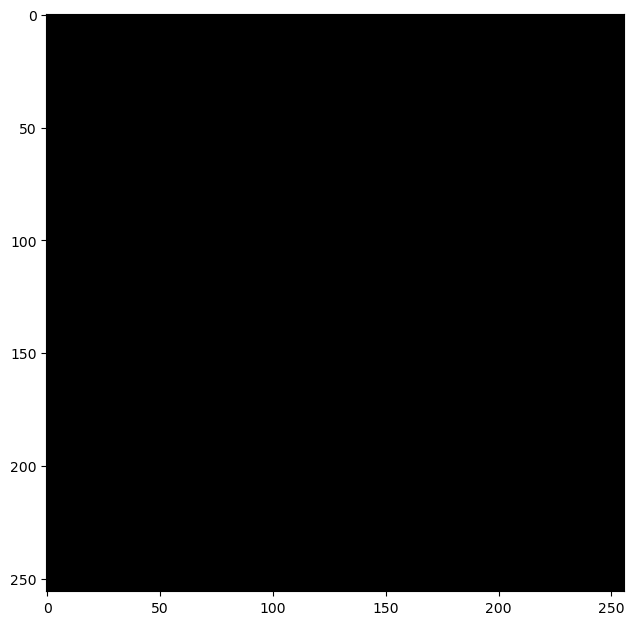

In [42]:
import matplotlib.pyplot as plt
plt.figure(plt.figure(figsize=(10, 7.5)))
plt.imshow(var_img[0,0].squeeze(1), cmap='gist_gray')

In [ ]:
var

# Creating the dictionary to have confident explanations


In [15]:
clcc = {111:'cont. urban fabric',
 112:'disc urban fabric',
 121:'industrial or commercial units',
 122:'road and rail',
 123:'port areas',
 124:'airports',
 131:'mineral extraction sites',
 132:'dump sites',
 133:'construction sites',
 141:'green urban areas',
 142:'sport and leasure',
 211:'non irregated arable land',
 212:'permenant irregated land',
 213:'rice fields',
 221:'vine yards',
 223:'olive groves',
 231:'pastures',
 241:'annual with perm. crops',
 242:'complex cultivation patters',
 243:'land principally occupied by agriculture',
 244:'agro forest areas',
 311:'broad leaved forest',
 312:'conferous forest',
 313:'mixed forest',
 321:'natural grassland',
 322:'moors and heathland',
 323: 'scierohllous vegitation',
 324:'transitional woodland shrub',
 331: 'beaches dunes and sand plains',
 332:'bare rock',
 333:'sparsely vegetated areas',
 334:'burnt areas',
 335:'glaciers and perpetual snow',
 411:'inland marshes',
 412:'peat bogs',
 421:'salt marshes',
 422:'salines',
 423:'intertidal flats',
 511:'water courses',
 512:'water bodies',
 521:'costal lagoons',
 522:'estuaries',
 523:'sea and ocean'}

In [18]:
def scale_to_minus_one_one(x, min_value, max_value):
    scaled_x = -1 + 2 * (x - min_value) / (max_value - min_value)
    return scaled_x

In [21]:
num_imgs = mean_var.size(0)
num_classes = mean_var.size(1)
variance_values = mean_var
class_names = clcc

def class_entropy(num_imgs, num_classes, class_names, variance_values):
    """Function to convet create a dictionary of each class

    Args:
        num_imgs (int): Nmber of input images.
        num_classes (int): Number of classes.
        class_names (dict): Dict of class names, the key is the class index, the value is the class name.

    Returns:
        dict: dict of class entropy, the key is the class index, the values are list with the first element being the class number and the second element being the entropy value.
    """


    # A data holder which contains the mean spatial pixel intensity of the entropy for each class across all the images we have
    class_pixel_mean_entropy = np.empty((num_imgs, num_classes))

    classes_dictionary = {}

    for i in range(num_imgs):
        for j in range(num_classes):
            # For image (i), class (j) ----> get a value between -1 and 1
            
            class_pixel_mean_entropy[i,j] = (scale_to_minus_one_one(variance_values[i,j], min(variance_values[i,:]), max(variance_values[i,:])))

    
    for i, key in enumerate(class_names.keys()):
        # Convert the class_names dictionary values to list, in order to be able to add other values
        classes_dictionary[key] = [class_names.get(key)]

    for i, key in enumerate(classes_dictionary.keys()):
        # Append the value of the entropy per class across all images at the dictionary
        if len(classes_dictionary[key]) == 1:
            # The condition to avoid overwriting at the key
            # we are adding the class number and the mean pixel entropy intensity
            classes_dictionary[key].append([i ,class_pixel_mean_entropy[:, i].mean()])            
    
    return classes_dictionary










        

In [22]:
classes_dict = class_entropy(num_imgs, num_classes, clcc, mean_var)
classes_dict

{111: ['cont. urban fabric', [0, -0.9768241375684739]],
 112: ['disc urban fabric', [1, -0.723114675283432]],
 121: ['industrial or commercial units', [2, -0.9384958237409592]],
 122: ['road and rail', [3, -0.9996115922927856]],
 123: ['port areas', [4, -0.999984472990036]],
 124: ['airports', [5, -0.9956092566251755]],
 131: ['mineral extraction sites', [6, -0.9916456520557404]],
 132: ['dump sites', [7, -0.9977326929569245]],
 133: ['construction sites', [8, -0.9952310383319855]],
 141: ['green urban areas', [9, -0.9920635521411896]],
 142: ['sport and leasure', [10, -0.9728315353393555]],
 211: ['non irregated arable land', [11, 0.11296100616455078]],
 212: ['permenant irregated land', [12, -0.9999999552965164]],
 213: ['rice fields', [13, -0.9999999523162841]],
 221: ['vine yards', [14, -0.999999949336052]],
 223: ['olive groves', [15, -0.9999999523162841]],
 231: ['pastures', [16, -0.9015174239873887]],
 241: ['annual with perm. crops', [17, -0.9999999403953552]],
 242: ['complex 

In [24]:
((36000/34) - (36000/40)) / (36000/34)

0.14999999999999994